<div class="alert alert-block alert-info">
Disclaimer: I am going to work with this notebook but the final changes will go on a python script
</div>

<div style="background-color: #bfd630; font-family: Calibri, sans-serif; padding: 20px;">
IMPORTANT: <br>
- we need to take care of the weird values like ages in X_test; we have smaller values for IME 4 count<br> 
NOT IMPORTANT: <br>
- how can we check for duplicates in a more efficient way? Instead of doing for loop per variable <br>
   
</div>

Things that were already did:
- drops:257901 (WCB), Claim Injury Type and WCB Decision and Agreement Reached (WCB),OIICS Nature of Injury Description (WCB & X_test), duplicates (WCB)
- WCB.replace(unknown_values, np.nan, inplace=True)  
- -9 from WCIO Part Of Body Code  -> 90, MULTIPLE BODY PARTS (WCB & X_test)


In [47]:
import pandas as pd
import numpy as np

from category_encoders import TargetEncoder

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # for missing values
import sys
sys.path.append('../helper_functions')

# data partition
from sklearn.model_selection import train_test_split

# Import functions that are stored in the helper_functions directory. We do this to keep the notebook clean and easy to read
from helper_functions import impute_with, days_between, target_encode_multiclass, invalid_entries, multiple_unique_values,  missing_data, impute_dates_with_difference, impute_prop, days_between, target_encode_multiclass, remove_outliers_iqr, iqr_date, log_remove_outliers_iqr

In [48]:
WCB_original = pd.read_csv('../project_data/train_data.csv', delimiter=',',dtype={'Zip Code': str})
X_test = pd.read_csv('../project_data/test_data.csv', delimiter=',',dtype={'Zip Code': str})

# show all columns
pd.set_option('display.max_columns', None)

WCB= WCB_original.copy() #This way we can access the original dataset if needed
WCB= WCB.drop(index=257901)

WCB.set_index('Claim Identifier', inplace=True)
X_test.set_index('Claim Identifier', inplace=True)


WCB= WCB.dropna(subset=['Claim Injury Type'])
WCB = WCB.drop(columns=['OIICS Nature of Injury Description'])
X_test =  X_test.drop(columns=['OIICS Nature of Injury Description'])


# Identify original missing values
date_columns = ['Accident Date', 'Assembly Date','C-2 Date', 'C-3 Date', 'First Hearing Date']
original_missing = WCB[date_columns].isna()
# Convert columns to datetime
for column in date_columns:
    WCB[column] = pd.to_datetime(WCB[column], format='%Y-%m-%d', errors='coerce')
    X_test[column] = pd.to_datetime(X_test[column], format='%Y-%m-%d', errors='coerce')


WCB = WCB.drop(index=5686771)



print("Before removing duplicates: ",WCB.shape[0],"\n")
# List of columns to check for duplicates
columns_to_check = ['Age at Injury', 'Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date',
                    'Alternative Dispute Resolution', 'Attorney/Representative', 'Average Weekly Wage',
                    'Carrier Name', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name',
                    'First Hearing Date', 'Birth Year', 'Gender', 'IME-4 Count', 'Industry Code',
                    'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Code',
                    'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
                    'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'Agreement Reached',
                    'WCB Decision', 'Claim Injury Type', 'Number of Dependents']

# Iterate over each column, excluding one at a time
for col in columns_to_check:
    # Define the subset of columns to check in this iteration (excluding 'col')
    cols_to_check_now = [c for c in columns_to_check if c != col]

    # Identify duplicates based on these columns
    duplicates = WCB[WCB.duplicated(subset=cols_to_check_now, keep=False)]

    #Drop duplicates, keeping the first occurrence in each subset where one column can differ
    WCB = WCB.drop_duplicates(subset=cols_to_check_now, keep='first')

print("After removing duplicates: ",WCB.shape[0],"\n")

WCB = WCB.drop(columns=['Agreement Reached'])

Before removing duplicates:  574025 

After removing duplicates:  573997 



In [49]:
#NEW
pd.set_option('display.max_rows', None)

print("=== Unique Zip Codes ===")
distinct_zip_prefixes = pd.Series(WCB['Zip Code'].unique())
#print(distinct_zip_prefixes)

pd.reset_option('display.max_rows')
#22-40;  M3K2B; M3K2C; T1S 0; N6C4E;  H1V2L; V6Z3G; KOC 1; V3H1H; L2H0H; L1C0K; JOL1B; SLV
#CONTINUE

=== Unique Zip Codes ===


In [50]:
# Get unique counts for each column
unique_counts = WCB.nunique()

# Filter columns with less than 1000 unique values
filtered_col = [col for col in unique_counts.index if unique_counts[col] < 1000]

# Display unique values for filtered columns
print("Unique values for each column:\n")
for col in filtered_col:
    print(f"{col} ({unique_counts[col]}): {WCB[col].unique()}\n")

Unique values for each column:

Age at Injury (108): [ 31.  46.  40.  61.  67.  48.  33.  55.  20.  21.  51.  62.  35.  54.
  32.  34.  38.  30.  36.  39.  44.  56.  29.  60.  49.  50.  18.  58.
  24.  45.  53.  52.  47.  25.  23.  22.  64.  70.  41.  69.  57.  27.
  42.  77.  72.  19.  28.  63.  65.  59.  43.  26.  74.  66.  76.  68.
  37.   0.  16.  71.  82.  75.  17.  78.  73.  89.  85.  84.  81.  87.
  80.  11.  88.  79.  15.  83.  86.  90.   1.  10. 102.  94. 117.  14.
 113.  95.  92. 104.   5.   8. 115. 110.  91.  96.  99.  12.  13.  93.
 101.   7. 111.   9.  97. 112. 109. 100.  98. 114.]

Alternative Dispute Resolution (3): ['N' 'Y' 'U']

Assembly Date (897): <DatetimeArray>
['2020-01-01 00:00:00', '2020-01-02 00:00:00', '2020-01-03 00:00:00',
 '2020-01-06 00:00:00', '2020-01-07 00:00:00', '2020-01-08 00:00:00',
 '2020-01-09 00:00:00', '2020-01-10 00:00:00', '2020-01-13 00:00:00',
 '2020-01-14 00:00:00',
 ...
 '2022-12-21 00:00:00', '2022-12-22 00:00:00', '2022-12-23 00:00:00',


In [51]:
#NEW
# Get unique counts for each column
unique_counts = X_test.nunique()

# Filter columns with less than 1000 unique values
filtered_col = [col for col in unique_counts.index if unique_counts[col] < 1000]

# Display unique values for filtered columns
print("Unique values for each column:\n")
for col in filtered_col:
    print(f"{col} ({unique_counts[col]}): {X_test[col].unique()}\n")

Unique values for each column:

Age at Injury (102): [ 19  59  55  25  36  43  40  48  51  57  67  39  56  42  66  31  32  34
  53  54  23  52  22  41  20  75  47  28  30  45  29  18  71  60  46  27
  64  65  37  50  62  58  33  24  35  38  21  49  70  61  44  26  63  74
   0  72  68  89  17  16  85  69  73  80  76  98  79  81  78  83  77  15
  82  88  84  14  86  87  97  11  10  93 113  12  90 100 104  96  95  94
   8  91  13   6  99  92   9 101 105 114   7   5]

Alternative Dispute Resolution (3): ['N' 'Y' 'U']

Assembly Date (434): <DatetimeArray>
['2023-01-02 00:00:00', '2023-01-03 00:00:00', '2023-01-04 00:00:00',
 '2023-01-05 00:00:00', '2023-01-06 00:00:00', '2023-01-07 00:00:00',
 '2023-01-09 00:00:00', '2023-01-10 00:00:00', '2023-01-11 00:00:00',
 '2023-01-12 00:00:00',
 ...
 '2024-05-23 00:00:00', '2024-05-24 00:00:00', '2024-05-27 00:00:00',
 '2024-05-28 00:00:00', '2024-05-29 00:00:00', '2024-05-30 00:00:00',
 '2024-05-31 00:00:00', '2024-06-03 00:00:00', '2024-06-04 00:00

<div class="alert alert-block alert-info">
Things we can find in X_test and not in WCB: <br> 
- We also have weird ages which we need to take care of 0,5,6,7... 100, 104, 99, 101, 105, 114 <br> 
- Birth Year does not have missing but also has 0's; here we don't have so many older people and we have a few younger that we don't have in WCB <br> 
- IME 4 count does not have so extreme values (not more than 20) we should probably take out outliers in WCB <br> 
- We do not have this type on Carrier Type 5C. SPECIAL FUND - POI CARRIER WCB MENANDS. Maybe we should group them (I think we already do this) <br> 
- We also have differences in WCIO Part Of Body Code' <br>
- 0.07% of 'X' gender now in WCB is 0.008% -> we should probably say in the report that in the future it might me a variable to consider in our model as it is growing
</div>

In [52]:
#NEW
codes_train = set(WCB['WCIO Part Of Body Code'].dropna())
codes_test = set(X_test['WCIO Part Of Body Code'].dropna())
print("Codes only in train:", codes_train - codes_test)
print("Codes only in test:", codes_test - codes_train)

desc_train = set(WCB['WCIO Part Of Body Description'].dropna())
desc_test = set(X_test['WCIO Part Of Body Description'].dropna())
print("Descriptions only in train:", desc_train - desc_test)
print("Descriptions only in test:", desc_test - desc_train)

Codes only in train: {40.0, 50.0, 90.0}
Codes only in test: set()
Descriptions only in train: {'MULTIPLE BODY PARTS (INCLUDING BODY', 'MULTIPLE LOWER EXTREMITIES', 'MULTIPLE TRUNK'}
Descriptions only in test: set()


In [53]:
WCB = WCB.drop(columns=['WCB Decision'])

unknown_values = {'Alternative Dispute Resolution': 'U',   'Carrier Type': 'UNKNOWN', 'County of Injury': 'UNKNOWN',
    'Gender': 'U','Medical Fee Region': 'UK'
}

for col, unknown in unknown_values.items():
  # Calculate the percentage of rows with the unknown value
  unknown_percentage = (WCB[WCB[col] == unknown].shape[0] / WCB.shape[0]) * 10
  print(f"Percentage of rows (WCB) where {col} == '{unknown}': {unknown_percentage:.5f}%")
#NEW 
for col, unknown in unknown_values.items():
  # Calculate the percentage of rows with the unknown value
  unknown_percentage = (X_test[X_test[col] == unknown].shape[0] / X_test.shape[0]) * 10
  print(f"Percentage of rows (X_test) where {col} == '{unknown}': {unknown_percentage:.5f}%")

Percentage of rows (WCB) where Alternative Dispute Resolution == 'U': 0.00009%
Percentage of rows (WCB) where Carrier Type == 'UNKNOWN': 0.03091%
Percentage of rows (WCB) where County of Injury == 'UNKNOWN': 0.02082%
Percentage of rows (WCB) where Gender == 'U': 0.08206%
Percentage of rows (WCB) where Medical Fee Region == 'UK': 0.58309%
Percentage of rows (X_test) where Alternative Dispute Resolution == 'U': 0.00003%
Percentage of rows (X_test) where Carrier Type == 'UNKNOWN': 0.04232%
Percentage of rows (X_test) where County of Injury == 'UNKNOWN': 0.02358%
Percentage of rows (X_test) where Gender == 'U': 0.13764%
Percentage of rows (X_test) where Medical Fee Region == 'UK': 0.54068%


In [54]:
WCB.replace(unknown_values, np.nan, inplace=True)
X_test.replace(unknown_values, np.nan, inplace=True) #NEW do we have this? 
#Same % of unknown variables

### 3.3. Checking Incoherencies<a class="anchor" id="checking-for-incoherencies"></a>
[Back to ToC](#toc)<br>

In [55]:
#NEW 
#this helps us make sense of why we decided to go with Carrier Type=5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)
X_test[X_test['Carrier Name'] == 'SPECIAL FUNDS SEC 25-A']

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6315441,1985-10-23,29,N,2023-07-21,N,NaN,NaN,NaT,NaT,SPECIAL FUNDS SEC 25-A,5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A),CAYUGA,N,SYRACUSE,NaT,F,NaN,61.0,EDUCATIONAL SERVICES,I,NaN,NaN,NaN,NaN,NaN,NaN,13092,4
6538808,2003-11-03,51,N,2024-05-16,N,0.0,1952.0,2024-05-14,NaT,SPECIAL FUNDS SEC 25-A,5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A),NASSAU,N,NYC,NaT,M,NaN,NaN,NaN,IV,57.0,PUSHING OR PULLING,52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,11514,0


In [56]:
multiple_unique_values(WCB,'Carrier Name','Carrier Type')

# Update the Carrier Type for rows where Carrier Name is 'SPECIAL FUNDS SEC 25-A'
WCB.loc[WCB['Carrier Name'] == 'SPECIAL FUNDS SEC 25-A', 'Carrier Type'] = '5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)'

Carrier Name with more than one unique value in Carrier Type:
SPECIAL FUNDS SEC 25-A: ['5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)'
 '5D. SPECIAL FUND - UNKNOWN']


In [57]:
#NEW 
#do you think we should do all we did here but with X_test? I checked before and I believe everything was the same but should we put to swhow we did it?
#And when do we make these changes in X_test? When we are doing for WCB or after? 
#multiple_unique_values(WCB,'WCIO Cause of Injury Code','WCIO Cause of Injury Description')

In [58]:
# Update the rows where 'WCIO Part Of Body Code' is -9
WCB.loc[WCB['WCIO Part Of Body Code'] == -9, 'WCIO Part Of Body Code'] = 90
WCB.loc[WCB['WCIO Part Of Body Code'] == 90, 'WCIO Part Of Body Description'] = 'MULTIPLE BODY PARTS'
# do the same for the test data
X_test.loc[X_test['WCIO Part Of Body Code'] == -9, 'WCIO Part Of Body Code'] = 90
X_test.loc[X_test['WCIO Part Of Body Code'] == 90, 'WCIO Part Of Body Description'] = 'MULTIPLE BODY PARTS'

In [59]:
# Replace all instances of Average Weekly Wage == 0 with NaN
WCB.loc[WCB['Average Weekly Wage'] == 0, 'Average Weekly Wage'] = np.nan
#NEW
X_test.loc[X_test['Average Weekly Wage'] == 0, 'Average Weekly Wage'] = np.nan


# Replace all instances of Birth Year == 0 with NaN
WCB.loc[WCB['Birth Year'] == 0, 'Birth Year'] = np.nan
X_test.loc[X_test['Birth Year'] == 0, 'Birth Year'] = np.nan


WCB.loc[(WCB['Number of Dependents'] > 0) & (WCB['Age at Injury'].between(1, 15)),'Number of Dependents']= 0
#NEW
X_test.loc[(X_test['Number of Dependents'] > 0) & (X_test['Age at Injury'].between(1, 15)),'Number of Dependents']= 0 

WCB.loc[WCB['Age at Injury']== 0,'Age at Injury']= np.nan
#NEW
X_test.loc[X_test['Age at Injury']== 0,'Age at Injury']= np.nan 

#### 3.3.11. Assembly Date<a class="anchor" id="incoherences-assembly"></a>
[Back to ToC](#toc)<br>

In [60]:
#invalid_entries_acc_ass=invalid_entries(X_test,'Accident Date','Assembly Date')
#222/X_test.shape[0]
#Number of invalid entries in Accident Date vs Assembly Date: 222
#0.0005722018171273923

#For WCB: 
# Number of invalid entries in Accident Date vs Assembly Date: 1407
# 0.002451232323513886


invalid_entries_acc_ass=invalid_entries(WCB,'Accident Date','Assembly Date')

Number of invalid entries in Accident Date vs Assembly Date: 1407


In [61]:
#NEW
invalid_WCB = WCB[
    (WCB['Accident Date'] > WCB['Assembly Date']) #&
    #(WCB['Accident Date'] > WCB['C-2 Date']) &
    #(WCB['Accident Date'] > WCB['C-3 Date']) 
    #(WCB['Accident Date'] > WCB['First Hearing Date'])
]

invalid_X_test = X_test[
    (X_test['Accident Date'] > X_test['Assembly Date']) #&
    #(X_test['Accident Date'] > X_test['C-2 Date']) &
    #(X_test['Accident Date'] > X_test['C-3 Date']) 
    #(X_test['Accident Date'] > X_test['First Hearing Date'])
]

print(f"Number of rows that don't respect the conditions in WCB: {len(invalid_WCB)}")
display(invalid_WCB)

print(f"\nNumber of rows that don't respect the conditions in X_test: {len(invalid_X_test)}")
invalid_X_test

#--------------------------------------------------------------------------------------------------
#Accident Date > Assembly Date 1407 rows WCB
#Accident Date > Assembly Date 222  rows X_test

#Accident Date > Assembly Date & Accident Date > C-2 Date 897 rows WCB
#Accident Date > Assembly Date & Accident Date > C-2 Date 165 rows X_test


#Accident Date > Assembly Date & Accident Date > C-3 Date 1072 rows WCB
#Accident Date > Assembly Date & Accident Date > C-3 Date 146  rows X_test

#Accident Date > Assembly Date & Accident Date > First Hearing Date 74 rows WCB
#Accident Date > Assembly Date & Accident Date > First Hearing Date 9  rows X_test



#Accident Date > Assembly Date & Accident Date > C-2 Date & Accident Date > C-3 Date 575 rows WCB
#Accident Date > Assembly Date & Accident Date > C-2 Date & Accident Date > C-3 Date 95  rows X_test



#Accident Date > Assembly Date & Accident Date > C-2 Date & Accident Date > C-3 Date & Accident Date > First Hearing Date 66 rows WCB
#Accident Date > Assembly Date & Accident Date > C-2 Date & Accident Date > C-3 Date & Accident Date > First Hearing Date 7  rows X_test

Number of rows that don't respect the conditions in WCB: 1407


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393953,2020-02-26,57.0,N,2020-01-01,Y,1997.87,1962.0,2019-12-31,2020-01-31,"CNY OTHER THAN ED, HED WATER",3A. SELF PUBLIC,5. PPD SCH LOSS,KINGS,N,NYC,2020-05-04,M,NaN,92.0,PUBLIC ADMINISTRATION,IV,97.0,REPETITIVE MOTION,71.0,"ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC",31.0,UPPER ARM,11226,0.0
5394099,2020-01-23,62.0,N,2020-01-02,Y,1775.89,1957.0,2020-01-14,2019-12-27,NYC TRANSIT AUTHORITY,3A. SELF PUBLIC,6. PPD NSL,QUEENS,N,NYC,2020-06-05,M,2.0,48.0,TRANSPORTATION AND WAREHOUSING,IV,99.0,"OTHER - MISCELLANEOUS, NOC",71.0,"ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC",90.0,MULTIPLE BODY PARTS,11001,3.0
5393830,2020-03-01,62.0,N,2020-01-02,Y,1467.47,1957.0,2020-01-17,2019-12-27,STATE INSURANCE FUND,2A. SIF,5. PPD SCH LOSS,ERIE,N,BUFFALO,2020-08-28,M,NaN,61.0,EDUCATIONAL SERVICES,I,52.0,CONTINUAL NOISE,31.0,HEARING LOSS OR IMPAIRMENT,13.0,EAR(S),NaN,1.0
5394613,2020-01-27,57.0,N,2020-01-03,Y,1450.00,NaN,2020-01-15,2019-12-30,NEW YORK CITY TRANSIT AUTH,3A. SELF PUBLIC,5. PPD SCH LOSS,NASSAU,N,NYC,2021-09-01,M,NaN,48.0,TRANSPORTATION AND WAREHOUSING,NaN,99.0,"OTHER - MISCELLANEOUS, NOC",31.0,HEARING LOSS OR IMPAIRMENT,13.0,EAR(S),28115,5.0
5394770,2020-01-23,56.0,N,2020-01-03,Y,1334.92,NaN,2020-01-06,2019-12-26,STATE INSURANCE FUND,2A. SIF,5. PPD SCH LOSS,NaN,N,NYC,2020-05-29,M,3.0,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,NaN,99.0,"OTHER - MISCELLANEOUS, NOC",78.0,CARPAL TUNNEL SYNDROME,34.0,WRIST,08736,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6162010,2023-02-02,52.0,N,2022-12-26,Y,992.39,1970.0,2022-12-26,NaT,MASSACHUSETTS BAY INS.CO.C/O,1A. PRIVATE,3. MED ONLY,ONEIDA,N,SYRACUSE,2023-11-16,M,3.0,53.0,REAL ESTATE AND RENTAL AND LEASING,II,97.0,REPETITIVE MOTION,52.0,STRAIN OR TEAR,39.0,WRIST (S) & HAND(S),13501,6.0
6162263,2022-12-28,55.0,N,2022-12-26,N,NaN,1967.0,2022-12-26,NaT,STATE INSURANCE FUND,2A. SIF,2. NON-COMP,BRONX,N,NYC,NaT,F,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,NaN,31.0,"FALL, SLIP OR TRIP, NOC",52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,07407,3.0
6161996,2022-12-30,33.0,N,2022-12-27,Y,2884.62,1989.0,2023-02-14,2022-12-20,"CNY OTHER THAN ED, HED WATER",3A. SELF PUBLIC,5. PPD SCH LOSS,SUFFOLK,N,HAUPPAUGE,2023-03-17,M,1.0,92.0,PUBLIC ADMINISTRATION,IV,97.0,REPETITIVE MOTION,52.0,STRAIN OR TEAR,90.0,MULTIPLE BODY PARTS,NaN,1.0



Number of rows that don't respect the conditions in X_test: 222


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6166393,2023-01-08,49.0,N,2023-01-03,Y,NaN,1973.0,2023-01-03,NaT,STATE INSURANCE FUND,2A. SIF,LEWIS,N,SYRACUSE,NaT,M,NaN,92.0,PUBLIC ADMINISTRATION,I,19.0,"CUT, PUNCTURE, SCRAPE, NOC",43.0,PUNCTURE,35.0,HAND,13309,3
6166531,2023-01-30,49.0,N,2023-01-04,Y,NaN,1974.0,2023-01-10,2022-12-29,NYC TRANSIT AUTHORITY,3A. SELF PUBLIC,KINGS,N,NYC,2024-04-18,M,NaN,48.0,TRANSPORTATION AND WAREHOUSING,NaN,99.0,"OTHER - MISCELLANEOUS, NOC",78.0,CARPAL TUNNEL SYNDROME,35.0,HAND,18466,3
6167475,2023-01-12,48.0,N,2023-01-05,Y,3800.85,1974.0,2023-12-02,2022-12-28,"CNY OTHER THAN ED, HED WATER",3A. SELF PUBLIC,WESTCHESTER,N,NYC,2024-02-28,M,NaN,92.0,PUBLIC ADMINISTRATION,III,97.0,REPETITIVE MOTION,71.0,"ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC",90.0,MULTIPLE BODY PARTS,10805,0
6168673,2023-02-01,39.0,N,2023-01-06,Y,226.00,NaN,2023-06-30,2022-12-29,SAFETY NATIONAL CASUALTY CORP,1A. PRIVATE,ORANGE,N,ALBANY,2023-08-23,M,NaN,33.0,MANUFACTURING,III,97.0,REPETITIVE MOTION,52.0,STRAIN OR TEAR,38.0,SHOULDER(S),10940,6
6167808,2023-01-31,55.0,N,2023-01-06,Y,2404.19,1967.0,2023-01-17,2023-01-04,STATE INSURANCE FUND,2A. SIF,JEFFERSON,N,SYRACUSE,2023-05-19,M,NaN,92.0,PUBLIC ADMINISTRATION,I,98.0,"CUMULATIVE, NOC",71.0,"ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC",35.0,HAND,13634,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6480079,2024-03-07,47.0,N,2024-02-26,Y,NaN,1977.0,2024-02-24,2024-04-15,"POLICE, FIRE, SANITATION",3A. SELF PUBLIC,NASSAU,N,NYC,2024-04-19,M,NaN,92.0,PUBLIC ADMINISTRATION,IV,99.0,"OTHER - MISCELLANEOUS, NOC",59.0,"ALL OTHER SPECIFIC INJURIES, NOC",90.0,MULTIPLE BODY PARTS,11554,6
6493804,2024-04-03,57.0,N,2024-03-14,N,NaN,1966.0,2024-03-14,NaT,NEW JERSEY MANUFACTURERS,1A. PRIVATE,ALBANY,N,NYC,NaT,M,NaN,61.0,EDUCATIONAL SERVICES,IV,98.0,"CUMULATIVE, NOC",80.0,"ALL OTHER CUMULATIVE INJURY, NOC",91.0,BODY SYSTEMS AND MULTIPLE BODY SYSTEMS,11232,4
6494572,2024-03-27,40.0,N,2024-03-15,Y,625.90,1984.0,2024-03-15,2024-04-09,SAFETY NATIONAL CASUALTY CORP,1A. PRIVATE,ONONDAGA,N,SYRACUSE,2024-05-06,M,NaN,42.0,WHOLESALE TRADE,I,97.0,REPETITIVE MOTION,52.0,STRAIN OR TEAR,35.0,HAND,13031,0


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_16404\2170016601.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invalid_WCB['Date Difference'] = (invalid_WCB['Accident Date'] - invalid_WCB['Assembly Date']).dt.days
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_16404\2170016601.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invalid_X_test['Date Difference'] = (invalid_X_test['Accident Date'] - invalid_X_test['Assembly Date']).dt.days


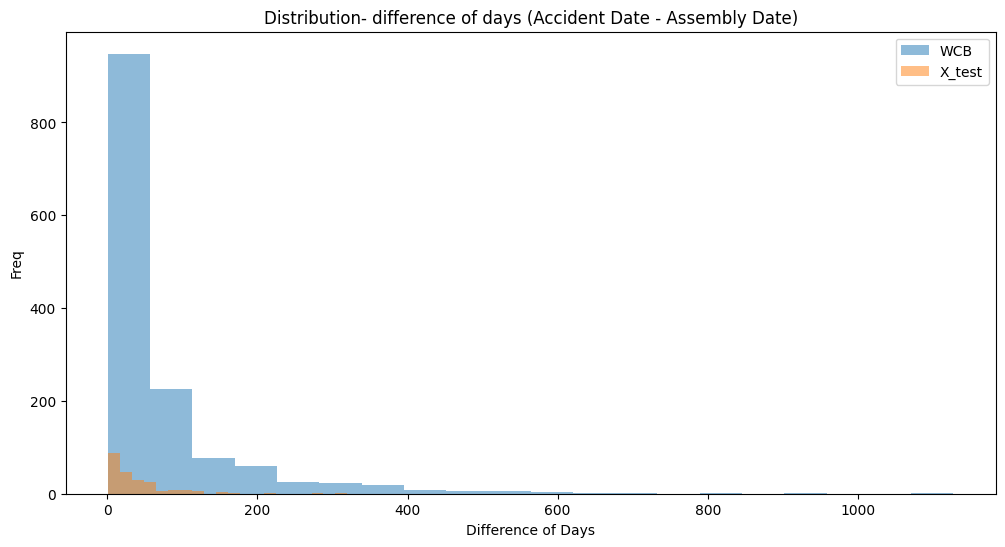

WCB:
count    1407.000000
mean       70.392324
std       106.205059
min         1.000000
25%        14.000000
50%        32.000000
75%        78.000000
max      1127.000000
Name: Date Difference, dtype: float64

 X_test:
count    222.000000
mean      38.779279
std       47.689616
min        1.000000
25%       10.000000
50%       22.000000
75%       50.000000
max      320.000000
Name: Date Difference, dtype: float64


In [62]:
WCB['Date Difference'] = (WCB['Accident Date'] - WCB['Assembly Date']).dt.days
X_test['Date Difference'] = (X_test['Accident Date'] - X_test['Assembly Date']).dt.days

invalid_WCB['Date Difference'] = (invalid_WCB['Accident Date'] - invalid_WCB['Assembly Date']).dt.days
invalid_X_test['Date Difference'] = (invalid_X_test['Accident Date'] - invalid_X_test['Assembly Date']).dt.days

plt.figure(figsize=(12, 6))
plt.hist(invalid_WCB['Date Difference'], bins=20, alpha=0.5, label='WCB')
plt.hist(invalid_X_test['Date Difference'], bins=20, alpha=0.5, label='X_test')
plt.title('Distribution- difference of days (Accident Date - Assembly Date)')
plt.xlabel('Difference of Days')
plt.ylabel('Freq')
plt.legend()
plt.show()

print("WCB:")
print(invalid_WCB['Date Difference'].describe())
print("\n X_test:")
print(invalid_X_test['Date Difference'].describe())

In [63]:
#"NEW" I don't know what to do here, why chabge with assembly date and not C2 date for example
invalid_entries_acc_ass_WCB=invalid_entries(WCB,'Accident Date','Assembly Date')
#NEW: did we have this?
invalid_entries_acc_ass_X_test=invalid_entries(X_test,'Accident Date','Assembly Date')
# Swap Accident Date and Assembly Date for invalid entries
WCB.loc[invalid_entries_acc_ass_WCB.index, ['Accident Date', 'Assembly Date']] = WCB.loc[invalid_entries_acc_ass_WCB.index, ['Assembly Date', 'Accident Date']].values

#NEW: did we have this?
X_test.loc[invalid_entries_acc_ass_X_test.index, ['Accident Date', 'Assembly Date']] = X_test.loc[invalid_entries_acc_ass_X_test.index, ['Assembly Date', 'Accident Date']].values
invalid_entries_acc_ass_WCB

Number of invalid entries in Accident Date vs Assembly Date: 1407
Number of invalid entries in Accident Date vs Assembly Date: 222


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents,Date Difference
Claim Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5393953,2020-02-26,57.0,N,2020-01-01,Y,1997.87,1962.0,2019-12-31,2020-01-31,"CNY OTHER THAN ED, HED WATER",3A. SELF PUBLIC,5. PPD SCH LOSS,KINGS,N,NYC,2020-05-04,M,NaN,92.0,PUBLIC ADMINISTRATION,IV,97.0,REPETITIVE MOTION,71.0,"ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC",31.0,UPPER ARM,11226,0.0,56.0
5394099,2020-01-23,62.0,N,2020-01-02,Y,1775.89,1957.0,2020-01-14,2019-12-27,NYC TRANSIT AUTHORITY,3A. SELF PUBLIC,6. PPD NSL,QUEENS,N,NYC,2020-06-05,M,2.0,48.0,TRANSPORTATION AND WAREHOUSING,IV,99.0,"OTHER - MISCELLANEOUS, NOC",71.0,"ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC",90.0,MULTIPLE BODY PARTS,11001,3.0,21.0
5393830,2020-03-01,62.0,N,2020-01-02,Y,1467.47,1957.0,2020-01-17,2019-12-27,STATE INSURANCE FUND,2A. SIF,5. PPD SCH LOSS,ERIE,N,BUFFALO,2020-08-28,M,NaN,61.0,EDUCATIONAL SERVICES,I,52.0,CONTINUAL NOISE,31.0,HEARING LOSS OR IMPAIRMENT,13.0,EAR(S),NaN,1.0,59.0
5394613,2020-01-27,57.0,N,2020-01-03,Y,1450.00,NaN,2020-01-15,2019-12-30,NEW YORK CITY TRANSIT AUTH,3A. SELF PUBLIC,5. PPD SCH LOSS,NASSAU,N,NYC,2021-09-01,M,NaN,48.0,TRANSPORTATION AND WAREHOUSING,NaN,99.0,"OTHER - MISCELLANEOUS, NOC",31.0,HEARING LOSS OR IMPAIRMENT,13.0,EAR(S),28115,5.0,24.0
5394770,2020-01-23,56.0,N,2020-01-03,Y,1334.92,NaN,2020-01-06,2019-12-26,STATE INSURANCE FUND,2A. SIF,5. PPD SCH LOSS,NaN,N,NYC,2020-05-29,M,3.0,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,NaN,99.0,"OTHER - MISCELLANEOUS, NOC",78.0,CARPAL TUNNEL SYNDROME,34.0,WRIST,08736,3.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6162010,2023-02-02,52.0,N,2022-12-26,Y,992.39,1970.0,2022-12-26,NaT,MASSACHUSETTS BAY INS.CO.C/O,1A. PRIVATE,3. MED ONLY,ONEIDA,N,SYRACUSE,2023-11-16,M,3.0,53.0,REAL ESTATE AND RENTAL AND LEASING,II,97.0,REPETITIVE MOTION,52.0,STRAIN OR TEAR,39.0,WRIST (S) & HAND(S),13501,6.0,38.0
6162263,2022-12-28,55.0,N,2022-12-26,N,NaN,1967.0,2022-12-26,NaT,STATE INSURANCE FUND,2A. SIF,2. NON-COMP,BRONX,N,NYC,NaT,F,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,NaN,31.0,"FALL, SLIP OR TRIP, NOC",52.0,STRAIN OR TEAR,42.0,LOWER BACK AREA,07407,3.0,2.0
6161996,2022-12-30,33.0,N,2022-12-27,Y,2884.62,1989.0,2023-02-14,2022-12-20,"CNY OTHER THAN ED, HED WATER",3A. SELF PUBLIC,5. PPD SCH LOSS,SUFFOLK,N,HAUPPAUGE,2023-03-17,M,1.0,92.0,PUBLIC ADMINISTRATION,IV,97.0,REPETITIVE MOTION,52.0,STRAIN OR TEAR,90.0,MULTIPLE BODY PARTS,NaN,1.0,3.0


In [64]:
invalid_entries_acc_c2=invalid_entries(X_test,'Accident Date','C-2 Date')
181/X_test.shape[0]

#For WCB: 
# Number of invalid entries in Accident Date vs C-2 Date: 982
# 0.0017108103352456547

Number of invalid entries in Accident Date vs C-2 Date: 29


0.0004665249049552162

In [65]:
invalid_entries_acc_c3=invalid_entries(X_test,'Accident Date','C-3 Date')
226/X_test.shape[0]

#For WCB:
# Number of invalid entries in Accident Date vs C-3 Date: 1289
# 0.0022456563361829417

Number of invalid entries in Accident Date vs C-3 Date: 213


0.0005825117597783362

In [66]:
invalid_entries_acc_1h=invalid_entries(X_test,'Accident Date','First Hearing Date')

#For WCB:
# Number of invalid entries in Accident Date vs First Hearing Date: 0

Number of invalid entries in Accident Date vs First Hearing Date: 0


In [67]:
#NEW What should we do? We are not using these dates so...
invalid_entries_ass_1h=invalid_entries(X_test,'Assembly Date','First Hearing Date')
9/X_test.shape[0]
#For WCB:
# Number of invalid entries in Accident Date vs First Hearing Date: 74
# 0.0001289205344278803


#NEW: Do  What other things should we be looking for?

Number of invalid entries in Assembly Date vs First Hearing Date: 9


2.3197370964624008e-05

In [68]:
#NEW but is it wrong?
invalid_entries_ass_1h=invalid_entries(X_test,'C-3 Date','First Hearing Date')
1126/X_test.shape[0]
#For WCB:
# Number of invalid entries in C-3 Date vs First Hearing Date: 3603
# 0.0062770362911304415

Number of invalid entries in C-3 Date vs First Hearing Date: 1126


0.0029022488562407372

In [69]:
#NEW but is it wrong?
invalid_entries_ass_1h=invalid_entries(X_test,'C-2 Date','First Hearing Date')
231/X_test.shape[0]
#For WCB:
# Number of invalid entries in C-2 Date vs First Hearing Date: 3927
# 0.006841499171598458

Number of invalid entries in C-2 Date vs First Hearing Date: 231


0.0005953991880920163

In [70]:
#NEW but it is not relevant, i thought that in cases where C-2 Date happens before C-3 Date (means that the company is perhaps more invested than the employee) it would be more prone to have non-comp or cancelled
# case_c2_before_c3 = WCB[WCB['C-2 Date']< WCB['C-3 Date']]
# case_c3_bwfore_c2 = WCB[WCB['C-3 Date']< WCB['C-2 Date']]

# dist_case_c2_before_c3 = case_c2_before_c3['Claim Injury Type'].value_counts(normalize=True) * 100
# dist_case_c3_before_c2= case_c3_bwfore_c2['Claim Injury Type'].value_counts(normalize=True)*100

# print("Distribution of 'Claim Injury Type' when 'C-2 Date' happens before 'C-3 Date'")
# print(dist_case_c2_before_c3, "\n")
# print("Distribution of 'Claim Injury Type' when 'C-2 Date' happens after 'C-3 Date'")
# print(dist_case_c3_before_c2)

---

In [71]:
X = WCB.drop(columns=['Claim Injury Type'])
y = WCB[['Claim Injury Type']]
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                 test_size = 0.3,
                                                 shuffle = True,
                                                 random_state = 0,
                                                 stratify = y)

In [72]:
print('There are', X_train.shape[0], 'rows in the train dataset')
print('There are', X_val.shape[0], 'rows in the val dataset')

#NEW we had commas that we don't need

There are 401797 rows in the train dataset
There are 172200 rows in the val dataset


In [73]:
missing_data(WCB)

,Missing Count,Missing %
IME-4 Count,441194,76.86
First Hearing Date,423201,73.73
C-3 Date,386761,67.38
Average Weekly Wage,364072,63.43
Birth Year,54155,9.43
Medical Fee Region,33469,5.83
Zip Code,28637,4.99
WCIO Part Of Body Code,17069,2.97
WCIO Part Of Body Description,17069,2.97
WCIO Nature of Injury Description,15643,2.73


In [74]:
#NEW
missing_data(X_test)

,Missing Count,Missing %
IME-4 Count,352726,90.91
First Hearing Date,344947,88.91
Average Weekly Wage,335753,86.54
C-3 Date,302759,78.04
Birth Year,39066,10.07
Medical Fee Region,20977,5.41
Zip Code,19342,4.99
WCIO Nature of Injury Description,10560,2.72
WCIO Nature of Injury Code,10560,2.72
WCIO Cause of Injury Description,10348,2.67


> NEW: There is a really high percentage of Average Weekly Wage missing, I think we should drop it

## 1. IME-4 Count <a class="anchor" id="IME-4 Count"></a>
[Back to ToC](#toc)<br>

>NEW: As we can see from the unique values, since the variable does not admit a value of zero, we can hypothesize that the missing values actually represent zeros. Claims without any IME-4 forms are more likely to be classified as 2. NON-COMP, which is precisely what we observe here:

In [75]:
#NEW
def analyze_distribution(df, column, target):
    # Filter the cases where the column is missing
    missing_cases = df[df[column].isna()]
    not_missing_cases = df[df[column].notna()]

    # Distribution of the target when the column is missing
    dist_missing = missing_cases[target].value_counts(normalize=True) * 100
    dist_not_missing = not_missing_cases[target].value_counts(normalize=True) * 100

    print(f"Distribution of '{target}' when '{column}' is NOT missing")
    print(dist_not_missing, "\n")
    print(f"Distribution of '{target}' when '{column}' is missing")
    print(dist_missing)

In [ ]:
analyze_distribution(WCB, 'Average Weekly Wage', 'Claim Injury Type')
#NEW variable: average weekly wage as binary

Distribution of 'Claim Injury Type' when 'Average Weekly Wage' is NOT missing
Claim Injury Type
4. TEMPORARY       63.284983
5. PPD SCH LOSS    21.851137
3. MED ONLY        12.351078
6. PPD NSL          1.897821
2. NON-COMP         0.356794
8. DEATH            0.167203
1. CANCELLED        0.046683
7. PTD              0.044302
Name: proportion, dtype: float64 

Distribution of 'Claim Injury Type' when 'Average Weekly Wage' is missing
Claim Injury Type
2. NON-COMP        79.739996
3. MED ONLY        11.804808
4. TEMPORARY        4.299424
1. CANCELLED        3.397954
5. PPD SCH LOSS     0.661682
6. PPD NSL          0.062350
8. DEATH            0.032686
7. PTD              0.001099
Name: proportion, dtype: float64


In [30]:
#NEW
analyze_distribution(WCB, 'IME-4 Count', 'Claim Injury Type')

Distribution of 'Claim Injury Type' when 'IME-4 Count' is NOT missing
Claim Injury Type
4. TEMPORARY       53.964895
5. PPD SCH LOSS    28.074667
3. MED ONLY        10.386061
2. NON-COMP         4.143732
6. PPD NSL          3.011980
1. CANCELLED        0.272584
8. DEATH            0.076052
7. PTD              0.070029
Name: proportion, dtype: float64 

Distribution of 'Claim Injury Type' when 'IME-4 Count' is missing
Claim Injury Type
2. NON-COMP        64.723682
4. TEMPORARY       17.415695
3. MED ONLY        12.491784
1. CANCELLED        2.744144
5. PPD SCH LOSS     2.492328
8. DEATH            0.083637
6. PPD NSL          0.047825
7. PTD              0.000907
Name: proportion, dtype: float64


> NEW: Thus, we will assume that the missing values are, in fact, zeros.

In [31]:
X_train['IME-4 Count'] = X_train['IME-4 Count'].fillna(0)
X_val['IME-4 Count'] = X_val['IME-4 Count'].fillna(0)
X_test['IME-4 Count'] = X_test['IME-4 Count'].fillna(0)

## 2. Dates <a class="anchor" id="dates"></a>
[Back to ToC](#toc)<br>

2.1. First Hearing Date

> NEW: Claims that never got a first hearing  are more likely to be classified as 2. NON-COMP, which is precisely what we observe here:

In [32]:
#NEW
analyze_distribution(WCB, 'First Hearing Date', 'Claim Injury Type')

Distribution of 'Claim Injury Type' when 'First Hearing Date' is NOT missing
Claim Injury Type
4. TEMPORARY       50.860102
5. PPD SCH LOSS    20.362609
3. MED ONLY        14.734476
2. NON-COMP         9.443884
6. PPD NSL          2.768641
1. CANCELLED        1.454283
8. DEATH            0.311679
7. PTD              0.064325
Name: proportion, dtype: float64 

Distribution of 'Claim Injury Type' when 'First Hearing Date' is missing
Claim Injury Type
2. NON-COMP        65.410762
4. TEMPORARY       16.968060
3. MED ONLY        11.031874
5. PPD SCH LOSS     4.152637
1. CANCELLED        2.428161
6. PPD NSL          0.008507
Name: proportion, dtype: float64


> NEW: __A blank date means the claim has not yet had a hearing held.__ this can be something to be aware because probably on X_test there are a lot of missings but that's just cause it hasn't happened yet 

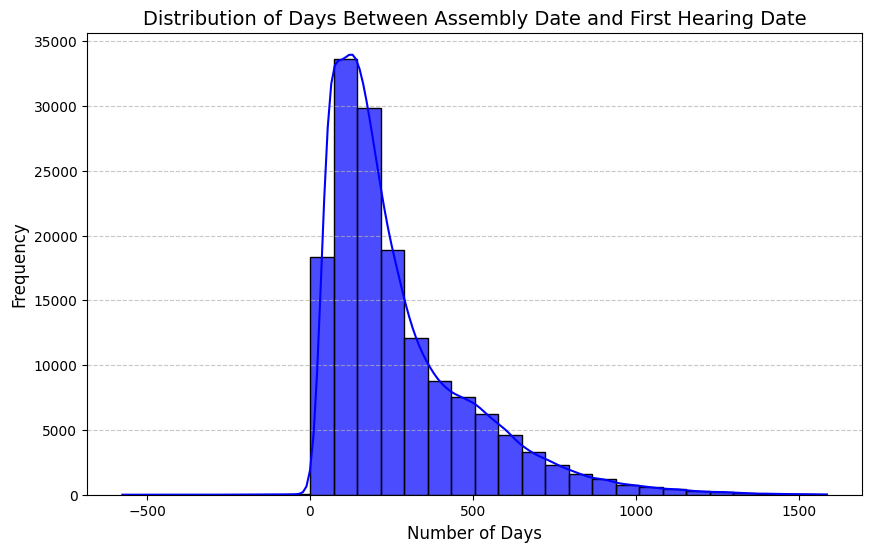

In [33]:
#NEW
WCB['Days Between'] = (WCB['First Hearing Date'] - WCB['Assembly Date']).dt.days

# Drop rows with missing values in 'Days Between'
days_between = WCB['Days Between'].dropna()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(days_between, bins=30, kde=True, color='blue', alpha=0.7)

# Add titles and labels
plt.title('Distribution of Days Between Assembly Date and First Hearing Date', fontsize=14)
plt.xlabel('Number of Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [34]:
#NEW
case_DB_less_200 = WCB[WCB['Days Between']<100]
case_DB_more_200 = WCB[WCB['Days Between']>400] 

dist_case_DB_less_200 = case_DB_less_200['Claim Injury Type'].value_counts(normalize=True) * 100
dist_case_DB_more_200 = case_DB_more_200['Claim Injury Type'].value_counts(normalize=True) * 100

print("Distribution of 'Claim Injury Type' when 'Days Between'<100")
print(dist_case_DB_less_200, "\n")
print("Distribution of 'Claim Injury Type' when 'Days Between'>400")
print(dist_case_DB_more_200)

Distribution of 'Claim Injury Type' when 'Days Between'<100
Claim Injury Type
4. TEMPORARY       45.040561
2. NON-COMP        25.060599
3. MED ONLY        12.365470
5. PPD SCH LOSS    11.977635
1. CANCELLED        2.824731
6. PPD NSL          1.790505
8. DEATH            0.853237
7. PTD              0.087263
Name: proportion, dtype: float64 

Distribution of 'Claim Injury Type' when 'Days Between'>400
Claim Injury Type
4. TEMPORARY       39.546737
5. PPD SCH LOSS    34.892752
3. MED ONLY        18.485483
6. PPD NSL          3.404023
2. NON-COMP         3.055126
1. CANCELLED        0.491490
7. PTD              0.066746
8. DEATH            0.057644
Name: proportion, dtype: float64


> NEW: We can observe that as the number of days between the Assembly Date and the First Hearing Date increases, the probability of NON-COMP decreases.     
Maybe we should add this variable but then we don't have info about the missing values and I don't know what value should we put? Small, big?     

Distribution of 'Claim Injury Type' when 'First Hearing Date' is missing    
Claim Injury Type     
"2. NON-COMP: 65.410762 <br>   
"4. TEMPORARY: 16.968060 <br> 
"3. MED ONLY: 11.031874 <br>
"5. PPD SCH LOSS: 4.152637 <br>
"1. CANCELLED: 2.428161 <br>
"6. PPD NSL: 0.008507 <br>


In [35]:
WCB['Claim Injury Type'].value_counts(normalize=True) * 100

Claim Injury Type
2. NON-COMP        50.707582
4. TEMPORARY       25.871912
3. MED ONLY        12.004592
5. PPD SCH LOSS     8.411194
1. CANCELLED        2.172311
6. PPD NSL          0.733628
8. DEATH            0.081882
7. PTD              0.016899
Name: proportion, dtype: float64

In [36]:
#NEW
# Grouping by Claim Injury Type and getting the descriptive statistics for each group
claim_injury_type_description = WCB.groupby('Claim Injury Type').describe()
claim_injury_type_description

Accident Date                                 \
                          count                           mean   
Claim Injury Type                                                
1. CANCELLED              11267  2020-04-22 13:04:44.050767872   
2. NON-COMP              289010  2021-05-24 15:35:44.902944256   
3. MED ONLY               68774  2021-07-09 03:33:44.195189760   
4. TEMPORARY             148206  2021-03-26 03:58:14.482004736   
5. PPD SCH LOSS           48280  2021-03-05 08:11:19.436620032   
6. PPD NSL                 4211  2021-01-02 22:37:35.236285952   
7. PTD                       97  2020-07-21 18:03:42.680412416   
8. DEATH                    470  2020-11-09 04:26:33.191489536   

                                                             \
                                   min                  25%   
Claim Injury Type                                             
1. CANCELLED       1961-09-06 00:00:00  2020-04-07 12:00:00   
2. NON-COMP        1963-10-01 00:00:00  2020-09-21 00:00:00   
3. MED ONLY        1994-06-27 00:00:00  2020-11-10 00:00:00   
4. TEMPORARY       1974-06-06 00:00:00  2020-09-18 00:00:00   
5. PPD SCH LOSS    2002-11-06 00:00:00  2020-07-22 00:00:00   
6. PPD NSL         2001-09-11 00:00:00  2020-06-09 00:00:00   
7. PTD             2002-02-28 00:00:00  2020-03-16 00:00:00   
8. DEATH           2016-12-15 00:00:00  2020-04-09 00:00:00   

                                                             \
                                   50%                  75%   
Claim Injury Type                                             
1. CANCELLED       2021-02-27 00:00:00  2022-01-04 00:00:00   
2. NON-COMP        2021-07-14 00:00:00  2022-04-04 00:00:00   
3. MED ONLY        2021-08-21 00:00:00  2022-05-01 00:00:00   
4. TEMPORARY       2021-06-29 00:00:00  2022-03-23 00:00:00   
5. PPD SCH LOSS    2021-02-28 00:00:00  2021-10-26 00:00:00   
6. PPD NSL         2020-12-23 00:00:00  2021-08-09 00:00:00   
7. PTD             2020-08-21 00:00:00  2021-03-19 00:00:00   
8. DEATH           2020-08-19 12:00:00  2021-07-09 06:00:00   

                                            Age at Injury                   \
                                   max  std         count       mean   min   
Claim Injury Type                                                            
1. CANCELLED       2022-12-26 00:00:00  NaN       10746.0  44.439047   7.0   
2. NON-COMP        2022-12-29 00:00:00  NaN      288171.0  41.155311   1.0   
3. MED ONLY        2022-12-30 00:00:00  NaN       68655.0  42.625184   7.0   
4. TEMPORARY       2022-12-30 00:00:00  NaN      147937.0  43.757890  14.0   
5. PPD SCH LOSS    2022-12-29 00:00:00  NaN       48259.0  45.663213  14.0   
6. PPD NSL         2022-12-19 00:00:00  NaN        4210.0  48.041805  17.0   
7. PTD             2022-08-29 00:00:00  NaN          97.0  53.412371  21.0   
8. DEATH           2022-11-24 00:00:00  NaN         468.0  54.946581   8.0   

                                                      Assembly Date  \
                    25%   50%   75%    max        std         count   
Claim Injury Type                                                     
1. CANCELLED       34.0  45.0  55.0  115.0  13.072204         12469   
2. NON-COMP        29.0  40.0  53.0  117.0  14.052755        291060   
3. MED ONLY        31.0  42.0  54.0   97.0  13.744495         68906   
4. TEMPORARY       33.0  44.0  54.0  100.0  13.177100        148504   
5. PPD SCH LOSS    36.0  46.0  55.0  113.0  12.274616         48280   
6. PPD NSL         39.0  49.0  57.0   90.0  11.984315          4211   
7. PTD             46.0  56.0  62.0   77.0  12.443834            97   
8. DEATH           46.0  56.5  64.0   89.0  14.423368           470   

                                                                       \
                                            mean                  min   
Claim Injury Type                                                       
1. CANCELLED       2021-07-22 12:14:01.8959

> NEW: Here we can see that the mean of AWW in 1. CANCELLED, 2. NON-COMP, 4. TEMPORARY is lower which shows that probably AWW plays a factor in determening the outcome (but also not really cause of the min). We can see that the variables: Date Difference and Days Between look important for these reason I am going to impute their missing values

In [37]:
#NEW CONTINUE to impute missing of these new variables









2.2. C-3 Date

In [38]:
#NEW
analyze_distribution(WCB, 'C-3 Date', 'Claim Injury Type')

Distribution of 'Claim Injury Type' when 'C-3 Date' is NOT missing
Claim Injury Type
4. TEMPORARY       42.177786
2. NON-COMP        20.362537
5. PPD SCH LOSS    19.875985
3. MED ONLY        12.733128
1. CANCELLED        2.993014
6. PPD NSL          1.790254
7. PTD              0.042193
8. DEATH            0.025102
Name: proportion, dtype: float64 

Distribution of 'Claim Injury Type' when 'C-3 Date' is missing
Claim Injury Type
2. NON-COMP        65.398011
4. TEMPORARY       17.978028
3. MED ONLY        11.651899
5. PPD SCH LOSS     2.860940
1. CANCELLED        1.774998
6. PPD NSL          0.222101
8. DEATH            0.109370
7. PTD              0.004654
Name: proportion, dtype: float64


> NEW: If we are not using the dates directly we don't need to impute them. Unless you want to use these new variables      
Number of invalid entries in Accident Date vs C-2 Date: 113     
Number of invalid entries in Accident Date vs C-2 Date: 52    
Number of invalid entries in Accident Date vs C-2 Date: 181   

In [39]:
#NEW
#Maybe instead of just using the median we could somehow use the median +/- some value given the time that happened between other dates
WCB['Days_Accident_Assembly'] = (WCB['Assembly Date'] - WCB['Accident Date']).dt.days
WCB['Days_Accident_FirstHearing'] = (WCB['First Hearing Date'] - WCB['Accident Date']).dt.days

threshold = WCB['Days_Accident_Assembly'].quantile(0.7)
top_group = WCB[WCB['Days_Accident_Assembly'] > threshold]
others = WCB[WCB['Days_Accident_Assembly'] <= threshold]

top_group_stats = top_group['Days_Accident_FirstHearing'].describe()
others_stats = others['Days_Accident_FirstHearing'].describe()

print("Statistics for 'Days between Accident and First Hearing' (Top Group):")
print(top_group_stats)
print("\nStatistics for 'Days between Accident and First Hearing' (Others):")
print(others_stats)


Statistics for 'Days between Accident and First Hearing' (Top Group):
count    54113.000000
mean       407.496868
std        661.330399
min         35.000000
25%        162.000000
50%        266.000000
75%        473.000000
max      16373.000000
Name: Days_Accident_FirstHearing, dtype: float64

Statistics for 'Days between Accident and First Hearing' (Others):
count    95234.000000
mean       294.843869
std        219.501056
min         22.000000
25%        141.000000
50%        224.000000
75%        391.000000
max       1598.000000
Name: Days_Accident_FirstHearing, dtype: float64


## 3. Average Weekly Wage <a class="anchor" id="aww"></a>
[Back to ToC](#toc)<br>

In [40]:
#NEW
WCB = WCB.drop(columns=['Average Weekly Wage'])
X_test = X_test.drop(columns=['Average Weekly Wage'])

> DROP or There are a lot of missing values but let's try to use it KNN, but first we need to take care of other missing values


## 4. Birth Year <a class="anchor" id="aww"></a>
[Back to ToC](#toc)<br>

In [41]:
WCB[(WCB['Birth Year'].isna()) & (WCB['Accident Date'].notna()) & (WCB['Age at Injury'].notna())].shape[0]
# Birth Year is missing: 54155 rows
# Birth Year is missing and Accident Date not missing: 53651 rows
# Birth Year is missing, Accident Date and Age at Injury not missing: 51971 rows

51971

In [42]:
#NEW
X_test[(X_test['Birth Year'].isna())].shape[0] # & (X_test['Accident Date'].notna()) & (X_test['Age at Injury'].notna())].shape[0]
# Birth Year is missing: 39066 rows
# Birth Year is missing and Accident Date not missing: 38731 rows
# Birth Year is missing, Accident Date and Age at Injury not missing: 38084 rows

39066

> NEW: The vast majority of missing values ​​for this variable can be resolved deterministically

In [43]:
# Rows to replace
filtered_rows_train =X_train[(X_train['Birth Year'].isna()) & (X_train['Accident Date'].notna()) & (X_train['Age at Injury'].notna())]

X_train.loc[filtered_rows_train.index, 'Birth Year'] = (
    X_train.loc[filtered_rows_train.index, 'Accident Date'].dt.year - X_train.loc[filtered_rows_train.index, 'Age at Injury']
)
# Rows to replace for validation set
filtered_rows_val= X_val[(X_val['Birth Year'].isna()) & (X_val['Accident Date'].notna()) & (X_val['Age at Injury'].notna())]

X_val.loc[filtered_rows_val.index, 'Birth Year'] = (
    X_val.loc[filtered_rows_val.index, 'Accident Date'].dt.year - X_val.loc[filtered_rows_val.index, 'Age at Injury']
)
# Rows to replace for test set
filtered_rows_test= X_test[(X_test['Birth Year'].isna()) & (X_test['Accident Date'].notna()) & (X_test['Age at Injury'].notna())]

X_test.loc[filtered_rows_test.index, 'Birth Year'] = (
    X_test.loc[filtered_rows_test.index, 'Accident Date'].dt.year - X_test.loc[filtered_rows_test.index, 'Age at Injury']
)




#NEW: What is this? It was in main
# put the median of the birth year in the missing values (from X_train) redundant 
# X_test['Birth Year'] = X_test['Birth Year'].fillna(X_train['Birth Year'].median())

In [44]:
#NEW
mean_age_at_injury = X_train['Age at Injury'].mean()
median_age_at_injury = X_train['Age at Injury'].median()
print(mean_age_at_injury)
print("\n", median_age_at_injury)
#median and mean are close, let's go with median because it's actually an age

42.50530372692967

 42.0


In [45]:
display(X_train[(X_train['Birth Year'].isna())  & (X_train['Accident Date'].notna())].shape[0])
#X_train:
#Birth Year is missing: 1514
#Birth Year is missing & Accident Date not missing: 1161

#X_val:
#Birth Year is missing: 670
#Birth Year is missing & Accident Date not missing: 519

#X_test:
#Birth Year is missing: 982
#Birth Year is missing & Accident Date not missing: 647
#we can see here that there is more % missing in the test set that we won't be able to solve right now

#display(X_val[(X_val['Birth Year'].isna())].shape[0])
#display(X_test[(X_test['Birth Year'].isna())].shape[0])

1161

In [46]:
#NEW
#Fill in 'Age at Injury' with the median when it is 'NaN' and 'Birth Year' is also 'NaN'
X_train.loc[X_train['Age at Injury'].isna() & X_train['Birth Year'].isna(), 'Age at Injury'] = median_age_at_injury
X_val.loc[X_val['Age at Injury'].isna() & X_val['Birth Year'].isna(), 'Age at Injury'] = median_age_at_injury
X_test.loc[X_test['Age at Injury'].isna() & X_test['Birth Year'].isna(), 'Age at Injury'] = median_age_at_injury

# Now let's calculate the year of birth deterministically again
X_train.loc[X_train['Birth Year'].isna() & X_train['Accident Date'].notna() & X_train['Age at Injury'].notna(), 'Birth Year'] = (
    X_train['Accident Date'].dt.year - X_train['Age at Injury']
)
X_val.loc[X_val['Birth Year'].isna() & X_val['Accident Date'].notna() & X_val['Age at Injury'].notna(), 'Birth Year'] = (
    X_val['Accident Date'].dt.year - X_val['Age at Injury']
)
X_test.loc[X_test['Birth Year'].isna() & X_test['Accident Date'].notna() & X_test['Age at Injury'].notna(), 'Birth Year'] = (
    X_test['Accident Date'].dt.year - X_test['Age at Injury']
)

In [ ]:
birth_year_negatives = X_train[X_train['Birth Year']> X_train['Accident Date'].dt.year ]
print(birth_year_negatives)

> NEW: Usually Assembly Date occurs in the same year as the Accident Date. For that reason we will use Assembly Date to impute the rest of the missing values

In [48]:
#NEW
X_train[X_train['Accident Date'].dt.year != X_train['Assembly Date'].dt.year].shape[0]
38829/X_train.shape[0]
#X_val:
#16826 rows (0.09771196283391405%)
#X_test:
#37995 rows (0.09793156775565436%)

0.09663835220272923

In [49]:
#NEW
X_train.loc[X_train['Birth Year'].isna() & X_train['Assembly Date'].notna() & X_train['Age at Injury'].notna(), 'Birth Year'] = (
    X_train['Assembly Date'].dt.year - X_train['Age at Injury']
)
X_val.loc[X_val['Birth Year'].isna() & X_val['Assembly Date'].notna() & X_val['Age at Injury'].notna(), 'Birth Year'] = (
    X_val['Assembly Date'].dt.year - X_val['Age at Injury']
)
X_test.loc[X_test['Birth Year'].isna() & X_test['Assembly Date'].notna() & X_test['Age at Injury'].notna(), 'Birth Year'] = (
    X_test['Assembly Date'].dt.year - X_test['Age at Injury']
)

## 5. Medical Fee Region, Zip Code, County of Injury <a class="anchor" id="locations"></a>
[Back to ToC](#toc)<br>

In [50]:
#CONTINUE

Age at Injury -> NEW (WCB['Age at Injury'] + WCB['Birth Year'] == WCB['Accident Date'].dt.year + 1) it is not a big deal but it's wrong
Gender
Carrier Type

Alternative Dispute Resolution


Age at Injury (determinístico),Accident Date,Carrier Type,
AWW, Gender KNN


## 6. Industry Code, WCIO Part Of Body, Nature & Cause of Injury Codes <a class="anchor" id="wcio"></a>
[Back to ToC](#toc)<br>

In [ ]:
#NEW
#analyze_distribution(WCB, 'Industry Code', 'Claim Injury Type')
#analyze_distribution(WCB, 'WCIO Part Of Body Code', 'Claim Injury Type')
#analyze_distribution(WCB, 'WCIO Cause of Injury Code', 'Claim Injury Type')
analyze_distribution(WCB, 'WCIO Nature of Injury Code', 'Claim Injury Type')
analyze_distribution(WCB, 'Average Weekly Wage', 'Claim Injury Type')

Distribution of 'Claim Injury Type' when 'WCIO Nature of Injury Code' is NOT missing
Claim Injury Type
2. NON-COMP        50.667677
4. TEMPORARY       26.541227
3. MED ONLY        12.316380
5. PPD SCH LOSS     8.642188
1. CANCELLED        0.978770
6. PPD NSL          0.754002
8. DEATH            0.082564
7. PTD              0.017193
Name: proportion, dtype: float64 

Distribution of 'Claim Injury Type' when 'WCIO Nature of Injury Code' is missing
Claim Injury Type
2. NON-COMP        52.131944
1. CANCELLED       44.774020
4. TEMPORARY        1.981717
3. MED ONLY         0.875791
5. PPD SCH LOSS     0.166209
8. DEATH            0.057534
6. PPD NSL          0.006393
7. PTD              0.006393
Name: proportion, dtype: float64


In [52]:
#NEW
# Filter the cases where the codes are missing
missing_cases = WCB[(WCB['Industry Code'].isna()) & (WCB['WCIO Nature of Injury Code'].isna()) & (WCB['WCIO Cause of Injury Code'].isna()) & (WCB['WCIO Part Of Body Code'].isna())]
not_missing_cases = WCB[~(WCB['Industry Code'].isna()) | ~(WCB['WCIO Nature of Injury Code'].isna()) | ~(WCB['WCIO Cause of Injury Code'].isna()) | ~(WCB['WCIO Part Of Body Code'].isna())]

dist_missing = missing_cases['Claim Injury Type'].value_counts(normalize=True) * 100
dist_not_missing = not_missing_cases['Claim Injury Type'].value_counts(normalize=True) * 100

print(f"Distribution of 'Claim Injury Type' when Codes are NOT missing")
print(dist_not_missing, "\n")
print(f"Distribution of 'Claim Injury Type' when Codes are missing")
print(dist_missing)

Distribution of 'Claim Injury Type' when Codes are NOT missing
Claim Injury Type
2. NON-COMP        50.581170
4. TEMPORARY       26.249122
3. MED ONLY        12.171064
5. PPD SCH LOSS     8.535324
1. CANCELLED        1.618576
6. PPD NSL          0.744655
8. DEATH            0.083113
7. PTD              0.016976
Name: proportion, dtype: float64 

Distribution of 'Claim Injury Type' when Codes are missing
Claim Injury Type
2. NON-COMP        59.117647
1. CANCELLED       39.011765
3. MED ONLY         0.929412
4. TEMPORARY        0.776471
5. PPD SCH LOSS     0.152941
7. PTD              0.011765
Name: proportion, dtype: float64


In [53]:
default_value_code = 100
default_value_desc = "Unknown"

# Columns with codes and descriptions
columns_code = ['WCIO Part Of Body Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code']
columns_desc = ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description']

# check if all thse columns are NaN for X_train and X_val
missing_condition_train = X_train[columns_code + columns_desc].isna().all(axis=1)
missing_condition_val = X_val[columns_code + columns_desc].isna().all(axis=1)
missing_condition_test = X_test[columns_code + columns_desc].isna().all(axis=1)

# Apply default values to X_train and X_val where conditions are met
for col in columns_code:
    X_train.loc[missing_condition_train, col] = default_value_code
    X_val.loc[missing_condition_val, col] = default_value_code
    X_test.loc[missing_condition_test, col] = default_value_code

for col in columns_desc:
    X_train.loc[missing_condition_train, col] = default_value_desc
    X_val.loc[missing_condition_val, col] = default_value_desc
    X_test.loc[missing_condition_test, col] = default_value_desc

In [54]:
#WCIO Part Of Body Code
part_body_93_data = WCB[WCB['WCIO Part Of Body Code'] == 10]

freq_part_body_93 = part_body_93_data['WCIO Nature of Injury Code'].value_counts(normalize=True)

freq_part_body_93 = freq_part_body_93.reset_index()
freq_part_body_93.columns = ['WCIO Nature of Injury Code', 'Relative Frequency']

print(freq_part_body_93)
print("SUM of FREQ:", freq_part_body_93['Relative Frequency'].sum())

    WCIO Nature of Injury Code  Relative Frequency
0                         10.0            0.431437
1                          7.0            0.145957
2                         40.0            0.139397
3                         59.0            0.070518
4                         52.0            0.039359
5                         49.0            0.030655
6                         90.0            0.028636
7                         53.0            0.023843
8                          1.0            0.015895
9                         37.0            0.015390
10                        25.0            0.009461
11                        43.0            0.006181
12                        77.0            0.005929
13                        28.0            0.005803
14                         4.0            0.005677
15                        80.0            0.004163
16                        68.0            0.002649
17                        32.0            0.002271
18                        65.0 

In [55]:
#For when WCIO Part Of Body Code is missing
unique_cause_codes = WCB['WCIO Nature of Injury Code'].dropna().unique() # unique values of WCIO Nature of Injury Code
filtered_frequencies = {}

# for each WCIO Cause of Injury Code
for cause_code in unique_cause_codes:
    filtered_data = WCB[WCB['WCIO Nature of Injury Code'] == cause_code] #get only rows with the same WCIO Nature of Injury Code 
    
    # Calculate relative frequencies
    freq_rel = filtered_data['WCIO Part Of Body Code'].value_counts(normalize=True)
    
    freq_rel = freq_rel.reset_index()
    freq_rel.columns = ['WCIO Part Of Body Code','Relative Frequency']
    
    # Calculate the cumulative sum of frequencies
    freq_rel['Cumulative Sum']= freq_rel['Relative Frequency'].cumsum()
    
    #Filter until the cumulative sum exceeds or reaches 0.5
    filtered_result = freq_rel[freq_rel['Cumulative Sum'] <= 0.5]
    
    # Add the next line that exceeds 0.5 to guarantee the minimum sum
    if not freq_rel[freq_rel['Cumulative Sum'] > 0.5].empty:
        filtered_result = pd.concat([filtered_result, freq_rel[freq_rel['Cumulative Sum'] > 0.5].iloc[:1]])

    filtered_frequencies[cause_code] = filtered_result[['WCIO Part Of Body Code', 'Relative Frequency']]

for cause_code, freq_table in filtered_frequencies.items():
    print(f"WCIO Nature of Injury Code: {cause_code}")
    print(freq_table)
    print("-" * 50)

WCIO Nature of Injury Code: 10.0
   WCIO Part Of Body Code  Relative Frequency
0                    90.0            0.165896
1                    53.0            0.126854
2                    56.0            0.055643
3                    35.0            0.054909
4                    18.0            0.052062
5                    36.0            0.038362
6                    42.0            0.037990
--------------------------------------------------
WCIO Nature of Injury Code: 49.0
   WCIO Part Of Body Code  Relative Frequency
0                    55.0            0.179928
1                    90.0            0.158129
2                    53.0            0.141529
3                    42.0            0.096727
--------------------------------------------------
WCIO Nature of Injury Code: 7.0
   WCIO Part Of Body Code  Relative Frequency
0                    18.0            0.246573
1                    10.0            0.211479
2                    11.0            0.199050
------------------

In [56]:
#WCIO Nature of Injury Code 125
6+3+2+1+2+5+7+6+3+3+5+1+4+2+6+1+1+4+6+2+2+5+1+2+1+3+4+3+2+2+2+1+1+2+4+3+1+2+2+2+2+3+2+3
#WCIO Cause of Injury Code 228

125

In [57]:
#For when WCIO Part Of Body Code is missing
unique_cause_codes = WCB['WCIO Cause of Injury Code'].dropna().unique() # unique values of Industry Code
filtered_frequencies = {}

# for each Industry Code
for cause_code in unique_cause_codes:
    filtered_data = WCB[WCB['WCIO Cause of Injury Code'] == cause_code] #get only rows with the same Industry Code 
    
    # Calculate relative frequencies
    freq_rel = filtered_data['WCIO Part Of Body Code'].value_counts(normalize=True)
    
    freq_rel = freq_rel.reset_index()
    freq_rel.columns = ['WCIO Part Of Body Code','Relative Frequency']
    
    # Calculate the cumulative sum of frequencies
    freq_rel['Cumulative Sum']= freq_rel['Relative Frequency'].cumsum()
    
    #Filter until the cumulative sum exceeds or reaches 0.5
    filtered_result = freq_rel[freq_rel['Cumulative Sum'] <= 0.5]
    
    # Add the next line that exceeds 0.5 to guarantee the minimum sum
    if not freq_rel[freq_rel['Cumulative Sum'] > 0.5].empty:
        filtered_result = pd.concat([filtered_result, freq_rel[freq_rel['Cumulative Sum'] > 0.5].iloc[:1]])

    filtered_frequencies[cause_code] = filtered_result[['WCIO Part Of Body Code', 'Relative Frequency']]

for cause_code, freq_table in filtered_frequencies.items():
    print(f"WCIO Cause of Injury Code: {cause_code}")
    print(freq_table)
    print("-" * 50)

WCIO Cause of Injury Code: 27.0
   WCIO Part Of Body Code  Relative Frequency
0                    53.0            0.232906
1                    90.0            0.202365
2                    42.0            0.106798
--------------------------------------------------
WCIO Cause of Injury Code: 97.0
   WCIO Part Of Body Code  Relative Frequency
0                    35.0            0.148428
1                    34.0            0.138206
2                    38.0            0.114499
3                    90.0            0.104965
--------------------------------------------------
WCIO Cause of Injury Code: 79.0
   WCIO Part Of Body Code  Relative Frequency
0                    36.0            0.133106
1                    56.0            0.115250
2                    35.0            0.087818
3                    90.0            0.056164
4                    53.0            0.051863
5                    14.0            0.046587
6                    37.0            0.044071
--------------------

In [ ]:
WCB[(WCB['Industry Code'].isna())  & (WCB['County of Injury'].notna())].shape[0]
#WCB: I used WCB because I wanted to impute the missing values with a variable that was not missing from the start
#'Industry Code' missing 9948 rows
#'Industry Code' missing & 'WCIO Part Of Body Code' not missing 1448 rows
#'Industry Code' missing & 'WCIO Cause of Injury Code' not missing 1021 rows
#'Industry Code' missing & 'WCIO Nature of Injury Code' not missing 995 rows 
#'Industry Code' missing & 'Carrier Name' not missing 9948 rows
#'Industry Code' missing & 'County of Injury' not missing 8799 rows -> we can "randomly" assing values respecting the proportion of 'Industry Code' for each 'County of Injury' ->NO, it doesn't bring variation
X_test[(X_test['Industry Code'].isna()) & (X_test['County of Injury'].notna())].shape[0]
#X_test:
#'Industry Code' missing 7736 rows
#'Industry Code' missing & 'County of Injury' not missing 7699 rows

7699

In [ ]:






#For when       is missing
unique_cause_codes = WCB['County of Injury'].dropna().unique() # unique values of County of Injury
filtered_frequencies = {}

# for each County of Injury
for cause_code in unique_cause_codes:
    filtered_data = WCB[WCB['County of Injury'] == cause_code] #get only rows with the same County of Injury
    
    # Calculate relative frequencies
    freq_rel = filtered_data['Industry Code'].value_counts(normalize=True)
    
    freq_rel = freq_rel.reset_index()
    freq_rel.columns = ['Industry Code','Relative Frequency']
    
    # Calculate the cumulative sum of frequencies
    freq_rel['Cumulative Sum']= freq_rel['Relative Frequency'].cumsum()
    
    #Filter until the cumulative sum exceeds or reaches 0.5
    filtered_result = freq_rel[freq_rel['Cumulative Sum'] <= 0.5]
    
    # Add the next line that exceeds 0.5 to guarantee the minimum sum
    if not freq_rel[freq_rel['Cumulative Sum'] > 0.5].empty:
        filtered_result = pd.concat([filtered_result, freq_rel[freq_rel['Cumulative Sum'] > 0.5].iloc[:1]])

    filtered_frequencies[cause_code] = filtered_result[['Industry Code', 'Relative Frequency']]

for cause_code, freq_table in filtered_frequencies.items():
    print(f"County of Injury: {cause_code}")
    print(freq_table)
    print("-" * 50)

County of Injury: ST. LAWRENCE
   Industry Code  Relative Frequency
0           92.0            0.243373
1           62.0            0.218976
2           61.0            0.113855
--------------------------------------------------
County of Injury: WYOMING
   Industry Code  Relative Frequency
0           92.0            0.236772
1           62.0            0.119048
2           23.0            0.072751
3           61.0            0.067460
4           33.0            0.066138
--------------------------------------------------
County of Injury: ORANGE
   Industry Code  Relative Frequency
0           92.0            0.219637
1           62.0            0.198414
2           44.0            0.073932
3           61.0            0.069034
--------------------------------------------------
County of Injury: DUTCHESS
   Industry Code  Relative Frequency
0           92.0            0.241751
1           62.0            0.218410
2           61.0            0.111618
-----------------------------------

In [ ]:
#For when Industry Code is missing
unique_cause_codes = WCB['WCIO Part Of Body Code'].dropna().unique() # unique values of Industry Code
filtered_frequencies = {}

# for each Industry Code
for cause_code in unique_cause_codes:
    filtered_data = WCB[WCB['WCIO Part Of Body Code'] == cause_code] #get only rows with the same Industry Code 
    
    # Calculate relative frequencies
    freq_rel = filtered_data['Industry Code'].value_counts(normalize=True)
    
    freq_rel = freq_rel.reset_index()
    freq_rel.columns = ['Industry Code','Relative Frequency']
    
    # Calculate the cumulative sum of frequencies
    freq_rel['Cumulative Sum']= freq_rel['Relative Frequency'].cumsum()
    
    #Filter until the cumulative sum exceeds or reaches 0.5
    filtered_result = freq_rel[freq_rel['Cumulative Sum'] <= 0.5]
    
    # Add the next line that exceeds 0.5 to guarantee the minimum sum
    if not freq_rel[freq_rel['Cumulative Sum'] > 0.5].empty:
        filtered_result = pd.concat([filtered_result, freq_rel[freq_rel['Cumulative Sum'] > 0.5].iloc[:1]])

    filtered_frequencies[cause_code] = filtered_result[['Industry Code', 'Relative Frequency']]

for cause_code, freq_table in filtered_frequencies.items():
    print(f"WCIO Nature of Injury Code: {cause_code}")
    print(freq_table)
    print("-" * 50)

WCIO Nature of Injury Code: 10.0
   Industry Code  Relative Frequency
0           62.0            0.240970
1           92.0            0.215358
2           61.0            0.124784
--------------------------------------------------
WCIO Nature of Injury Code: 49.0
   Industry Code  Relative Frequency
0           48.0            0.183435
1           62.0            0.153290
2           92.0            0.146166
3           44.0            0.061187
--------------------------------------------------
WCIO Nature of Injury Code: 7.0
   Industry Code  Relative Frequency
0           62.0            0.195220
1           61.0            0.131180
2           92.0            0.090494
3           44.0            0.089400
--------------------------------------------------
WCIO Nature of Injury Code: 43.0
   Industry Code  Relative Frequency
0           62.0            0.371227
1           54.0            0.098563
2           92.0            0.095274
--------------------------------------------------

In [ ]:
#OLD
X_train = impute_with(X_train, 'WCIO Part Of Body Code', 'WCIO Cause of Injury Code', metric='mode')
X_val = impute_with(X_val, 'WCIO Part Of Body Code', 'WCIO Cause of Injury Code',reference_df=X_train, metric='mode')
X_test = impute_with(X_test, 'WCIO Part Of Body Code', 'WCIO Cause of Injury Code',reference_df=X_train, metric='mode')

# DataFrame with unique WCIO Part Of Body Codes and their descriptions (without missing descriptions)
body_code_description_train = X_train[['WCIO Part Of Body Code', 'WCIO Part Of Body Description']].drop_duplicates()
body_code_description_train = body_code_description_train[body_code_description_train['WCIO Part Of Body Description'].notna()]

# Dictionary to map WCIO Part Of Body Code to its description
description_dict = dict(zip(body_code_description_train['WCIO Part Of Body Code'], body_code_description_train['WCIO Part Of Body Description']))

# Fill missing descriptions in X_train, X_val, X_test using the mapping | This is redundant as we dropo the description column later
X_train['WCIO Part Of Body Description'] = X_train['WCIO Part Of Body Description'].fillna(X_train['WCIO Part Of Body Code'].map(description_dict))
X_val['WCIO Part Of Body Description'] = X_val['WCIO Part Of Body Description'].fillna(X_val['WCIO Part Of Body Code'].map(description_dict))
X_test['WCIO Part Of Body Description'] = X_test['WCIO Part Of Body Description'].fillna(X_test['WCIO Part Of Body Code'].map(description_dict))




X_train = impute_with(X_train, 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', metric='mode')
X_val = impute_with(X_val, 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',reference_df=X_train, metric='mode')
X_test = impute_with(X_test, 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',reference_df=X_train, metric='mode')

# DataFrame with unique WCIO Nature of Injury Codes and their descriptions (in X_train and without missing descriptions)
nature_code_description_train = X_train[['WCIO Nature of Injury Code', 'WCIO Nature of Injury Description']].drop_duplicates()
nature_code_description_train = nature_code_description_train[nature_code_description_train['WCIO Nature of Injury Description'].notna()]

# Dictionary to map WCIO Nature of Injury Code to its description
description_dict = dict(zip(nature_code_description_train['WCIO Nature of Injury Code'], nature_code_description_train['WCIO Nature of Injury Description']))

# Fill missing descriptions in the original DataFrame using the mapping | redundant as we drop the values later 
X_train['WCIO Nature of Injury Description'] = X_train['WCIO Nature of Injury Description'].fillna(X_train['WCIO Nature of Injury Code'].map(description_dict))
X_val['WCIO Nature of Injury Description'] = X_val['WCIO Nature of Injury Description'].fillna(X_val['WCIO Nature of Injury Code'].map(description_dict))
X_test['WCIO Nature of Injury Description'] = X_test['WCIO Nature of Injury Description'].fillna(X_test['WCIO Nature of Injury Code'].map(description_dict))




X_train = impute_with(X_train, 'WCIO Cause of Injury Code', 'WCIO Part Of Body Code', metric='mode')
X_val = impute_with(X_val, 'WCIO Cause of Injury Code', 'WCIO Part Of Body Code',reference_df=X_train, metric='mode')
X_test = impute_with(X_test, 'WCIO Cause of Injury Code', 'WCIO Part Of Body Code',reference_df=X_train, metric='mode')

# DataFrame with unique WCIO Cause of Injury Codes and their descriptions (in X_train and without missing descriptions)
cause_code_description_train = X_train[['WCIO Cause of Injury Code', 'WCIO Cause of Injury Description']].drop_duplicates()
cause_code_description_train = cause_code_description_train[cause_code_description_train['WCIO Cause of Injury Description'].notna()]

# Dictionary to map WCIO Cause of Injury Code to its description (based on X_train)
description_dict_train = dict(zip(cause_code_description_train['WCIO Cause of Injury Code'], cause_code_description_train['WCIO Cause of Injury Description']))

# Fill missing descriptions in X_train and X_val using the mapping
X_train['WCIO Cause of Injury Description'] = X_train['WCIO Cause of Injury Description'].fillna(X_train['WCIO Cause of Injury Code'].map(description_dict_train))
X_val['WCIO Cause of Injury Description'] = X_val['WCIO Cause of Injury Description'].fillna(X_val['WCIO Cause of Injury Code'].map(description_dict_train))
X_test['WCIO Cause of Injury Description'] = X_test['WCIO Cause of Injury Description'].fillna(X_test['WCIO Cause of Injury Code'].map(description_dict_train))

In [172]:
unique_cause_codes = WCB['WCIO Cause of Injury Code'].dropna().unique() # unique values of WCIO Cause of Injury Code
filtered_frequencies = {}

# for each WCIO Cause of Injury Code
for cause_code in unique_cause_codes:
    filtered_data = WCB[WCB['WCIO Cause of Injury Code'] == cause_code] #get only rows with the same WCIO Cause of Injury Code 
    
    # Calculate relative frequencies
    freq_rel = filtered_data['WCIO Nature of Injury Code'].value_counts(normalize=True)
    
    freq_rel = freq_rel.reset_index()
    freq_rel.columns = ['WCIO Nature of Injury Code','Relative Frequency']
    
    # Calculate the cumulative sum of frequencies
    freq_rel['Cumulative Sum']= freq_rel['Relative Frequency'].cumsum()
    
    #Filter until the cumulative sum exceeds or reaches 0.5
    filtered_result = freq_rel[freq_rel['Cumulative Sum'] <= 0.5]
    
    # Add the next line that exceeds 0.5 to guarantee the minimum sum
    if not freq_rel[freq_rel['Cumulative Sum'] > 0.5].empty:
        filtered_result = pd.concat([filtered_result, freq_rel[freq_rel['Cumulative Sum'] > 0.5].iloc[:1]])

    filtered_frequencies[cause_code] = filtered_result[['WCIO Nature of Injury Code', 'Relative Frequency']]

for cause_code, freq_table in filtered_frequencies.items():
    print(f"WCIO Cause of Injury Code: {cause_code}")
    print(freq_table)
    print("-" * 50)


WCIO Cause of Injury Code: 27.0
   WCIO Nature of Injury Code  Relative Frequency
0                        10.0            0.355022
1                        52.0            0.280059
--------------------------------------------------
WCIO Cause of Injury Code: 97.0
   WCIO Nature of Injury Code  Relative Frequency
0                        52.0             0.51551
--------------------------------------------------
WCIO Cause of Injury Code: 79.0
   WCIO Nature of Injury Code  Relative Frequency
0                        10.0            0.402959
1                        40.0            0.129739
--------------------------------------------------
WCIO Cause of Injury Code: 16.0
   WCIO Nature of Injury Code  Relative Frequency
0                        40.0            0.697541
--------------------------------------------------
WCIO Cause of Injury Code: 31.0
   WCIO Nature of Injury Code  Relative Frequency
0                        10.0            0.320717
1                        52.0       

In [173]:
filtered_frequencies = {}

# for each WCIO Cause of Injury Code
for cause_code in unique_cause_codes:
    filtered_data = WCB[WCB['WCIO Cause of Injury Code'] == cause_code] #get only rows with the same WCIO Cause of Injury Code 
    
    # Calculate relative frequencies
    freq_rel = filtered_data['WCIO Part Of Body Code'].value_counts(normalize=True)
    
    freq_rel = freq_rel.reset_index()
    freq_rel.columns = ['WCIO Part Of Body Code','Relative Frequency']
    
    # Calculate the cumulative sum of frequencies
    freq_rel['Cumulative Sum']= freq_rel['Relative Frequency'].cumsum()
    
    #Filter until the cumulative sum exceeds or reaches 0.5
    filtered_result = freq_rel[freq_rel['Cumulative Sum'] <= 0.5]
    
    # Add the next line that exceeds 0.5 to guarantee the minimum sum
    if not freq_rel[freq_rel['Cumulative Sum'] > 0.5].empty:
        filtered_result = pd.concat([filtered_result, freq_rel[freq_rel['Cumulative Sum'] > 0.5].iloc[:1]])

    filtered_frequencies[cause_code] = filtered_result[['WCIO Part Of Body Code', 'Relative Frequency']]

for cause_code, freq_table in filtered_frequencies.items():
    print(f"WCIO Cause of Injury Code: {cause_code}")
    print(freq_table)
    print("-" * 50)

WCIO Cause of Injury Code: 27.0
   WCIO Part Of Body Code  Relative Frequency
0                    53.0            0.232906
1                    90.0            0.202365
2                    42.0            0.106798
--------------------------------------------------
WCIO Cause of Injury Code: 97.0
   WCIO Part Of Body Code  Relative Frequency
0                    35.0            0.148428
1                    34.0            0.138206
2                    38.0            0.114499
3                    90.0            0.104965
--------------------------------------------------
WCIO Cause of Injury Code: 79.0
   WCIO Part Of Body Code  Relative Frequency
0                    36.0            0.133106
1                    56.0            0.115250
2                    35.0            0.087818
3                    90.0            0.056164
4                    53.0            0.051863
5                    14.0            0.046587
6                    37.0            0.044071
--------------------

---

In [ ]:
X_train_copy = X_train.copy() 
X_val_copy = X_val.copy()

In [ ]:
# List with the date columns with outliers
dates_with_outliers = ['Accident Date','C-2 Date','C-3 Date']

In [ ]:
for date in dates_with_outliers:
  X_train_copy = X_train_copy[X_train_copy[date].ge('2018-01-01') | X_train_copy[date].isna()]
  X_val_copy = X_val_copy[X_val_copy[date].ge('2018-01-01') | X_val_copy[date].isna()]

In [ ]:
# Creating a column in X_train_copy and X_val_copy that calculates the days between Accident Date and Assembly Date
X_train_copy.loc[:, 'days_between_accident_assembly'] = days_between(X_train_copy, 'Accident Date', 'Assembly Date')
X_val_copy.loc[:, 'days_between_accident_assembly'] = days_between(X_val_copy, 'Accident Date', 'Assembly Date')

# Add log transformation column in X_train
X_train_copy['log_days_between_accident_assembly'] = np.log1p(X_train_copy['days_between_accident_assembly'])

# Using the remove_outliers_iqr function created in helper_functions we'll 
lower, upper, X_train_copy = log_remove_outliers_iqr(X_train_copy,'log_days_between_accident_assembly',2)

X_val_copy = X_val_copy[X_val_copy['days_between_accident_assembly']<upper]


# Dropping the columns created
X_train_copy = X_train_copy.drop('days_between_accident_assembly', axis=1)
X_train_copy = X_train_copy.drop('log_days_between_accident_assembly', axis=1)
X_val_copy = X_val_copy.drop('days_between_accident_assembly', axis=1)

In [ ]:
# Selecting only the numerical columns
numerical_cols = ['Age at Injury','Average Weekly Wage','Birth Year','IME-4 Count','Number of Dependents']

# Remove outlier in X_train, obtain lower and upper bound and apply to X_val
lower, upper, X_train_copy = remove_outliers_iqr(X_train_copy,'Age at Injury')

# Apply the same upper bound to X_val_copy
X_val_copy = X_val_copy[X_val_copy['Age at Injury']<upper]

# Apply minimum of 11 years old to X_train_copy and X_val_copy
X_train_copy = X_train_copy[X_train_copy['Age at Injury']>11]
X_val_copy = X_val_copy[X_val_copy['Age at Injury']>=11]

percentile_99 = X_train_copy['Average Weekly Wage'].quantile(0.9999)
# Apply conditions to the training set first
X_train_copy = X_train_copy[(X_train_copy['Average Weekly Wage'] < percentile_99)]

# Apply the same conditions to the validation set
X_val_copy = X_val_copy[(X_val_copy['Average Weekly Wage'] < percentile_99)]
# Add log transformation column
X_train_copy['log_avg_weekly_wage'] = np.log1p(X_train_copy['Average Weekly Wage'])
# Threshold of 2 for a more conservative range
lower,upper,X_train_copy = log_remove_outliers_iqr(X_train_copy,'log_avg_weekly_wage',2)
# Apply upper bound to X_train_copy and X_val_copy
X_val_copy = X_val_copy[(X_val_copy['Average Weekly Wage'] < upper)]

#NEW: I would use 20
X_train_copy = X_train_copy[(X_train_copy['IME-4 Count'] < 40)]
X_val_copy = X_val_copy[(X_val_copy['IME-4 Count'] < 40)]

In [ ]:
X_train = X_train_copy.copy()
X_val = X_val_copy.copy()

# after we have cleaned the data we need to exclude the index out of the y_train and y_val 
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

#NEW "It is important to highlight.." we have this twice in our notebook
#NEW we should actually apply some log transformation like for AWW
#NEW Are there any similar works/applications? What has been done? What did other researchers find? What would you expect your results to be based on their previous findings?

Considere imputar valores ausentes com base na mediana de Industry Code e Age at Injury.
Impute com base na combinação mais comum dentro do setor (Industry Code) ou da região (County of Injury).


---

In [ ]:
# create some copies of the train dataframes
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()
X_test_encoded = X_test.copy()



X_train_encoded_original_index = X_train.index
X_val_encoded_original_index = X_val.index
X_test_encoded_original_index = X_test.index

In [ ]:
#BINARY
# print how many na and non na values are in the following columns C-2 Date, C-3 Date, First Hearing Date
date_binary = ['C-2 Date', 'C-3 Date', 'First Hearing Date']
for col in date_binary:
    na_count = X_train_encoded[col].isna().sum()
    non_na_count = X_train_encoded[col].notna().sum()
    print(f"Column '{col}':")
    print(f"  NA values: {na_count}")
    print(f"  Non-NA values: {non_na_count}\n")


# encode the variables and put 1 for non na and 0 for na for the training set
X_train_encoded['C-2 Date'] = X_train_encoded['C-2 Date'].notna().astype(int)
X_train_encoded['C-3 Date'] = X_train_encoded['C-3 Date'].notna().astype(int)
X_train_encoded['First Hearing Date'] = X_train_encoded['First Hearing Date'].notna().astype(int)

# encode the variables and put 1 for non na and 0 for na for the validation set
X_val_encoded['C-2 Date'] = X_val_encoded['C-2 Date'].notna().astype(int)
X_val_encoded['C-3 Date'] = X_val_encoded['C-3 Date'].notna().astype(int)
X_val_encoded['First Hearing Date'] = X_val_encoded['First Hearing Date'].notna().astype(int)

# encode the variables and put 1 for non na and 0 for na for the validation set
X_test_encoded['C-2 Date'] = X_test_encoded['C-2 Date'].notna().astype(int)
X_test_encoded['C-3 Date'] = X_test_encoded['C-3 Date'].notna().astype(int)
X_test_encoded['First Hearing Date'] = X_test_encoded['First Hearing Date'].notna().astype(int)

In [ ]:
# Define the binary variables and mapping
binary_vars = ['Alternative Dispute Resolution', 'Attorney/Representative', 'COVID-19 Indicator']
binary_mapping = {'Y': 1, 'N': 0}

# Apply mapping to binary variables

for var in binary_vars:
    X_train_encoded[var] = X_train_encoded[var].map(binary_mapping)

# Apply for validation set
for var in binary_vars:
    X_val_encoded[var] = X_val_encoded[var].map(binary_mapping)

# Apply for validation set
for var in binary_vars:
    X_test_encoded[var] = X_test_encoded[var].map(binary_mapping)

# convert all columns into int values
# X_train_encoded[binary_vars] = X_train_encoded[binary_vars].astype(int)

# Gender to binary mapping
gender_mapping = {'M': 1, 'F': 0}
X_train_encoded['Gender'] = X_train_encoded['Gender'].map(gender_mapping)
X_val_encoded['Gender'] = X_val_encoded['Gender'].map(gender_mapping)
X_test_encoded['Gender'] = X_test_encoded['Gender'].map(gender_mapping )

In [ ]:
# Define the mapping
carrier_type_mapping = {
    '1A. PRIVATE': 'Private Insurance Carrier',
    '2A. SIF': 'State Insurance Fund',
    '3A. SELF PUBLIC': 'Self-insured Public Entity',
    '4A. SELF PRIVATE': 'Self-insured Private Entity',
    '5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)': 'Special Funds',
    '5C. SPECIAL FUND - POI CARRIER WCB MENANDS': 'Special Funds',
    '5D. SPECIAL FUND - UNKNOWN': 'Special Funds',
    'UNKNOWN': 'Unknown'
}

# apply for training set
    # Step 2: Apply the mapping to create 'Carrier Group'
if 'Carrier Type' in X_train.columns:

    X_train_encoded['Carrier Group'] = X_train_encoded['Carrier Type'].map(carrier_type_mapping)
    X_train_encoded['Carrier Group'] =X_train_encoded['Carrier Group'].fillna('Other')


    # Step 3: Encode 'Carrier Group' using One-Hot Encoding
X_train_encoded =   pd.concat([X_train_encoded, pd.get_dummies(X_train_encoded['Carrier Group'],
                        columns=['Carrier Group'],
                        prefix='CarrierGroup',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
                        axis=1
                    )


# apply for valdiation set
    # Step 4: Apply the mapping to create 'Carrier Group' for x_val_encoded
if 'Carrier Type' in X_val.columns:

    X_val_encoded['Carrier Group'] = X_val_encoded['Carrier Type'].map(carrier_type_mapping)
    X_val_encoded['Carrier Group'] =X_val_encoded['Carrier Group'].fillna('Other')


    # Step 5: Encode 'Carrier Group' using One-Hot Encoding for X_val_encoded
X_val_encoded = pd.concat([X_val_encoded, pd.get_dummies(X_val_encoded['Carrier Group'],
                        columns=['Carrier Group'],
                        prefix='CarrierGroup',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
                        axis=1
                )

# apply for test set
# Step 4: Apply the mapping to create 'Carrier Group' for x_test_encoded
if 'Carrier Type' in X_test.columns:

    X_test_encoded['Carrier Group'] = X_test_encoded['Carrier Type'].map(carrier_type_mapping)
    X_test_encoded['Carrier Group'] = X_test_encoded['Carrier Group'].fillna('Other')


    # Step 5: Encode 'Carrier Group' using One-Hot Encoding for X_test_encoded
X_test_encoded = pd.concat([X_test_encoded, pd.get_dummies(X_test_encoded['Carrier Group'],
                        columns=['Carrier Group'],
                        prefix='CarrierGroup',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
                        axis=1
                )

In [ ]:
# apply the target encoding to the industry code column | target encoding is defined in the helper functions    
X_train_encoded, X_val_encoded = target_encode_multiclass(X_train_encoded, X_val_encoded,  y_train, 'Industry Code', 'Claim Injury Type')

# set the index back to the original index
X_train_encoded.set_index(X_train_encoded_original_index, inplace=True)
X_val_encoded.set_index(X_val_encoded_original_index, inplace=True)

# apply to  test set / This is not working yet because we probably need to clean the test set first
X_test_encoded = target_encode_multiclass(X_train_encoded, X_test_encoded,  y_train, 'Industry Code', 'Claim Injury Type')[1]
# set index back to the original index
X_test_encoded.set_index(X_test_encoded_original_index, inplace=True)

In [ ]:
# transform the column into int from float for training set
X_train_encoded['WCIO Cause of Injury Code'] = X_train_encoded['WCIO Cause of Injury Code'].astype(int)

# transform the column into int from float for validation set
X_val_encoded['WCIO Cause of Injury Code'] = X_val_encoded['WCIO Cause of Injury Code'].astype(int)

# transform the column into int from float for test set
X_test_encoded['WCIO Cause of Injury Code'] = X_test_encoded['WCIO Cause of Injury Code'].astype(int)

In [ ]:
# Mapping WCIO Cause of Injury codes to more general categories for modeling

# Define the mapping dictionary
wcio_cause_of_injury_map = {

    # Category: Burn or Scald
    # Injury types related to exposure to heat, cold, chemicals, or radiation
    1: "Burn_or_Scald", 2: "Burn_or_Scald", 3: "Burn_or_Scald",
    4: "Burn_or_Scald", 5: "Burn_or_Scald", 6: "Burn_or_Scald",
    7: "Burn_or_Scald", 8: "Burn_or_Scald", 9: "Burn_or_Scald",
    11: "Burn_or_Scald", 14: "Burn_or_Scald", 84: "Burn_or_Scald",

    # Category: Caught In
    # Injuries caused by being caught in or under machinery or objects
    10: "Caught_In", 12: "Caught_In", 13: "Caught_In",
    20: "Caught_In",

    # Category: Cut, Puncture, Scrape
    # Injuries involving cuts, punctures, and abrasions
    15: "Cut_Puncture_Scrape", 16: "Cut_Puncture_Scrape", 17: "Cut_Puncture_Scrape",
    18: "Cut_Puncture_Scrape", 19: "Cut_Puncture_Scrape",

    # Category: Fall, Slip or Trip
    # Injuries due to falls, slips, or trips at various levels
    25: "Fall_Slip_or_Trip", 26: "Fall_Slip_or_Trip", 27: "Fall_Slip_or_Trip",
    28: "Fall_Slip_or_Trip", 29: "Fall_Slip_or_Trip", 30: "Fall_Slip_or_Trip",
    31: "Fall_Slip_or_Trip", 32: "Fall_Slip_or_Trip", 33: "Fall_Slip_or_Trip",

    # Category: Motor Vehicle
    # Injuries related to motor vehicle incidents
    40: "Motor_Vehicle", 41: "Motor_Vehicle", 45: "Motor_Vehicle",
    46: "Motor_Vehicle", 47: "Motor_Vehicle", 48: "Motor_Vehicle",
    50: "Motor_Vehicle",

    # Category: Strain or Injury
    # Injuries resulting from physical strain, overuse, or repetitive motions
    52: "Strain_or_Injury", 53: "Strain_or_Injury", 54: "Strain_or_Injury",
    55: "Strain_or_Injury", 56: "Strain_or_Injury", 57: "Strain_or_Injury",
    58: "Strain_or_Injury", 59: "Strain_or_Injury", 60: "Strain_or_Injury",
    61: "Strain_or_Injury", 97: "Strain_or_Injury",

    # Category: Striking Against or Stepping On
    # Injuries from striking against or stepping on objects
    65: "Striking_Against_or_Stepping_On", 66: "Striking_Against_or_Stepping_On", 67: "Striking_Against_or_Stepping_On",
    68: "Striking_Against_or_Stepping_On", 69: "Striking_Against_or_Stepping_On", 70: "Striking_Against_or_Stepping_On",

    # Category: Struck or Injured By
    # Injuries caused by being struck by objects or individuals
    74: "Struck_or_Injured_By", 75: "Struck_or_Injured_By", 76: "Struck_or_Injured_By",
    77: "Struck_or_Injured_By", 78: "Struck_or_Injured_By", 79: "Struck_or_Injured_By",
    80: "Struck_or_Injured_By", 81: "Struck_or_Injured_By", 85: "Struck_or_Injured_By",
    86: "Struck_or_Injured_By",

    # Category: Rubbed or Abraded By
    # Injuries caused by rubbing or abrasion, such as callouses or blisters
    94: "Rubbed_or_Abraded_By", 95: "Rubbed_or_Abraded_By",

    # Category: Miscellaneous Causes
    # Other injury causes not otherwise classified
    82: "Miscellaneous_Causes", 83: "Miscellaneous_Causes",  87: "Miscellaneous_Causes", 88: "Miscellaneous_Causes",
    89: "Miscellaneous_Causes", 90: "Miscellaneous_Causes", 91: "Miscellaneous_Causes", 93: "Miscellaneous_Causes",
    94: "Miscellaneous_Causes", 95: "Miscellaneous_Causes", 96: "Miscellaneous_Causes", 98: "Miscellaneous_Causes",
    99: "Miscellaneous_Causes",

    # Category: Unknown
    100: "Unknown"
    
}

In [ ]:
# create mapping
X_train_encoded['Injury_Cause_Category'] = X_train_encoded['WCIO Cause of Injury Code'].map(wcio_cause_of_injury_map)
X_val_encoded['Injury_Cause_Category'] = X_val_encoded['WCIO Cause of Injury Code'].map(wcio_cause_of_injury_map)
X_test_encoded['Injury_Cause_Category'] = X_test_encoded['WCIO Cause of Injury Code'].map(wcio_cause_of_injury_map)

In [ ]:
# create dummy variables based on the Injury_cause_Category
X_train_encoded = pd.concat([X_train_encoded, pd.get_dummies(X_train_encoded['Injury_Cause_Category'],
                        columns=['Injury_Cause_Category'],
                        prefix='Injury_Cause',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)

X_train_encoded.head().T

X_val_encoded = pd.concat([X_val_encoded, pd.get_dummies(X_val_encoded['Injury_Cause_Category'],
                        columns=['Injury_Cause_Category'],
                        prefix='Injury_Cause',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)

X_test_encoded = pd.concat([X_test_encoded, pd.get_dummies(X_test_encoded['Injury_Cause_Category'],
                        columns=['Injury_Cause_Category'],
                        prefix='Injury_Cause',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)

In [ ]:
X_train_encoded, X_val_encoded = target_encode_multiclass(X_train_encoded, X_val_encoded, y_train, 'Injury_Cause_Category', 'Claim Injury Type')


# set the index back to the original index
X_train_encoded.set_index(X_train_encoded_original_index, inplace=True)
X_val_encoded.set_index(X_val_encoded_original_index, inplace=True)


X_test_encoded = target_encode_multiclass(X_train_encoded, X_test_encoded, y_train, 'Injury_Cause_Category', 'Claim Injury Type')[1]
# set the index back to the original index
X_test_encoded.set_index(X_test_encoded_original_index, inplace=True)

In [ ]:
# transform the column into int from float for training set
X_train_encoded['WCIO Nature of Injury Code'] = X_train_encoded['WCIO Nature of Injury Code'].astype(int)

# transform the column into int from float for validation set
X_val_encoded['WCIO Nature of Injury Code'] = X_val_encoded['WCIO Nature of Injury Code'].astype(int)

# transform the column into int from float for test set
X_test_encoded['WCIO Nature of Injury Code'] = X_test_encoded['WCIO Nature of Injury Code'].astype(int)

In [ ]:
# Mapping WCIO Nature of Injury codes to general categories
wcionature_of_injury_mapping = {

    # Category: Specific
    # Injuries categorized as specific, meaning they are distinct and isolated injuries
    1: "Specific", 2: "Specific", 3: "Specific",
    4: "Specific", 7: "Specific", 10: "Specific",
    13: "Specific", 16: "Specific", 19: "Specific",
    22: "Specific", 25: "Specific", 28: "Specific",
    30: "Specific", 31: "Specific", 32: "Specific",
    34: "Specific", 36: "Specific", 37: "Specific",
    38: "Specific", # 38 refers to ADVERSE REACTION TO A VACCINATION OR INOCULATION classify as Specific
    40: "Specific", 41: "Specific", 42: "Specific",
    43: "Specific", 46: "Specific", 47: "Specific",
    49: "Specific", 52: "Specific", 53: "Specific",
    54: "Specific", 55: "Specific", 58: "Specific",
    59: "Specific",

    # Category: Occupational
    # Injuries related to occupational disease or cumulative trauma
    60: "Occupational", 61: "Occupational", 62: "Occupational",
    63: "Occupational", 64: "Occupational", 65: "Occupational",
    66: "Occupational", 67: "Occupational", 68: "Occupational",
    69: "Occupational", 70: "Occupational", 71: "Occupational",
    72: "Occupational", 73: "Occupational", 74: "Occupational",
    75: "Occupational", 76: "Occupational", 77: "Occupational",
    78: "Occupational", 79: "Occupational", 80: "Occupational",
    83: "Occupational", # 83 refers to covid. I classified it as occupational

    # Category: Multiple
    # Injuries that involve multiple types, either physical or both physical and psychological
    90: "Multiple", 91: "Multiple",

    # Category: Unknown
    100: "Unknown"
}

In [ ]:
# map for validation set
X_train_encoded['Injury_Nature_Category'] = X_train_encoded['WCIO Nature of Injury Code'].map(wcionature_of_injury_mapping)

# map for validation set
X_val_encoded['Injury_Nature_Category'] = X_val_encoded['WCIO Nature of Injury Code'].map(wcionature_of_injury_mapping)

# map for test set
X_test_encoded['Injury_Nature_Category'] = X_test_encoded['WCIO Nature of Injury Code'].map(wcionature_of_injury_mapping)

In [ ]:
# create dummy variables out of Injury_Nature_Category column


# create a dummy varialbes for the Injury Category for training set
X_train_encoded = pd.concat([X_train_encoded, pd.get_dummies(X_train_encoded['Injury_Nature_Category'],
                        columns=['Nature_Injury'],
                        prefix='Nature_Injury',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)



# create a dummy varialbes for the Injury Category for validation set
X_val_encoded = pd.concat([X_val_encoded, pd.get_dummies(X_val_encoded['Injury_Nature_Category'],
                        columns=['Nature_Injury'],
                        prefix='Nature_Injury',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)


# create a dummy varialbes for the Injury Category for validation set
X_test_encoded = pd.concat([X_test_encoded, pd.get_dummies(X_test_encoded['Injury_Nature_Category'],
                        columns=['Nature_Injury'],
                        prefix='Nature_Injury',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
                        axis=1)

In [ ]:
# apply encoding for Injury_Nature_Category
X_train_encoded, X_val_encoded = target_encode_multiclass(X_train_encoded, X_val_encoded, y_train, 'Injury_Nature_Category', 'Claim Injury Type')

# set the index back to the original index
X_train_encoded.set_index(X_train_encoded_original_index, inplace=True)
X_val_encoded.set_index(X_val_encoded_original_index, inplace=True)


# apply encoding for Injury_Nature_Category to the test set
X_test_encoded = target_encode_multiclass(X_train_encoded, X_test_encoded, y_train, 'Injury_Nature_Category', 'Claim Injury Type')[1]
# set the index back to the original index
X_test_encoded.set_index(X_test_encoded_original_index, inplace=True)

In [ ]:
# transform the column into int from float for training set
X_train_encoded['WCIO Part Of Body Code'] = X_train_encoded['WCIO Part Of Body Code'].astype(int)

# transform the column into int from float for validation set
X_val_encoded['WCIO Part Of Body Code'] = X_val_encoded['WCIO Part Of Body Code'].astype(int)

# transform the column into int from float for validation set
X_test_encoded['WCIO Part Of Body Code'] = X_test_encoded['WCIO Part Of Body Code'].astype(int)

In [ ]:
part_of_body_map = {
    # Head and Neck
    10: 'Head_and_Neck', 14: 'Head_and_Neck', 17: 'Head_and_Neck',
    18: 'Head_and_Neck', 15: 'Head_and_Neck', 13: 'Head_and_Neck',
    12: 'Head_and_Neck', 16: 'Head_and_Neck', 20: 'Head_and_Neck',
    25: 'Head_and_Neck', 24: 'Head_and_Neck', 26: 'Head_and_Neck',
    11: 'Head_and_Neck', 19: 'Head_and_Neck', 21:'Head_and_Neck',
    22:'Head_and_Neck',23:'Head_and_Neck',

    # Upper Extremities
    30: 'Upper_Extremities', 31: 'Upper_Extremities', 32: 'Upper_Extremities',
    33: 'Upper_Extremities', 34: 'Upper_Extremities', 35: 'Upper_Extremities',
    36: 'Upper_Extremities', 37: 'Upper_Extremities', 38: 'Upper_Extremities',
    39: 'Upper_Extremities',

    # Trunk
    40: 'Trunk', 41: 'Trunk', 42: 'Trunk', 43: 'Trunk', 44: 'Trunk',
    45: 'Trunk', 46: 'Trunk', 47: 'Trunk', 48: 'Trunk', 49: 'Trunk',
    60: 'Trunk', 61: 'Trunk', 62: 'Trunk', 63: 'Trunk',

    # Lower Extremities
    50: 'Lower_Extremities', 51: 'Lower_Extremities', 52: 'Lower_Extremities',
    53: 'Lower_Extremities', 54: 'Lower_Extremities', 55: 'Lower_Extremities',
    56: 'Lower_Extremities', 57: 'Lower_Extremities', 58: 'Lower_Extremities',

    # Multiple Body Parts
    64: 'Multiple_Body Parts', 65: 'Multiple_Body Parts', 66: 'Multiple_Body Parts',
    90: 'Multiple_Body Parts', 91: 'Multiple_Body Parts', 99: 'Multiple_Body Parts',

    # Unknown
    100: 'Unknown'
}

In [ ]:
# map for training set
X_train_encoded['Part_Body_Category'] = X_train_encoded['WCIO Part Of Body Code'].map(part_of_body_map)

# map for training set
X_val_encoded['Part_Body_Category'] = X_val_encoded['WCIO Part Of Body Code'].map(part_of_body_map)

# map for training set
X_test_encoded['Part_Body_Category'] = X_test_encoded['WCIO Part Of Body Code'].map(part_of_body_map)

In [ ]:
# create a dummy varialbes for the Part of Body Category for training set
X_train_encoded = pd.concat([X_train_encoded, pd.get_dummies(X_train_encoded['Part_Body_Category'],
                        columns=['Part_Body_Category'],
                        prefix='Body_Part',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)


# create a dummy variable for the Part of Body Category for val set
X_val_encoded = pd.concat([X_val_encoded, pd.get_dummies(X_val_encoded['Part_Body_Category'],
                        columns=['Part_Body_Category'],
                        prefix='Body_Part',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)

# create a dummy varialbes for the Part of Body Category for training set
X_test_encoded = pd.concat([X_test_encoded, pd.get_dummies(X_test_encoded['Part_Body_Category'],
                        columns=['Part_Body_Category'],
                        prefix='Body_Part',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)


In [ ]:
# apply encoding for Injury_Nature_Category
X_train_encoded, X_val_encoded = target_encode_multiclass(X_train_encoded, X_val_encoded, y_train, 'Part_Body_Category', 'Claim Injury Type')

# set the index back to the original index
X_train_encoded.set_index(X_train_encoded_original_index, inplace=True)
X_val_encoded.set_index(X_val_encoded_original_index, inplace=True)

# apply encoding for Injury_Nature_Category to the test set
X_test_encoded = target_encode_multiclass(X_train_encoded, X_test_encoded, y_train, 'Part_Body_Category', 'Claim Injury Type')[1]

# set the index back to the original index
X_test_encoded.set_index(X_test_encoded_original_index, inplace=True)

In [ ]:
#NEW we need to write assembly right
X_train_encoded.loc[:,'Days_between_Acc_Assembyl'] = days_between(X_train_encoded, 'Accident Date','Assembly Date')
X_val_encoded.loc[:,'Days_between_Acc_Assembyl'] = days_between(X_val_encoded, 'Accident Date','Assembly Date')
X_test_encoded.loc[:,'Days_between_Acc_Assembyl'] = days_between(X_test_encoded, 'Accident Date','Assembly Date')

In [ ]:
columns_to_keep = ['Age at Injury', 'Alternative Dispute Resolution','Attorney/Representative', 'Average Weekly Wage', 'Birth Year', 'C-2 Date', 'C-3 Date', 'COVID-19 Indicator', 'First Hearing Date', 'Gender', 'IME-4 Count', 'Number of Dependents', 'CarrierGroup_Self-insured Private Entity', 'CarrierGroup_Self-insured Public Entity', 'CarrierGroup_Special Funds', 'CarrierGroup_State Insurance Fund', 'Industry Code_encoded_5. PPD SCH LOSS','Industry Code_encoded_2. NON-COMP','Industry Code_encoded_3. MED ONLY', 'Industry Code_encoded_4. TEMPORARY','Industry Code_encoded_1. CANCELLED', 'Industry Code_encoded_8. DEATH', 'Industry Code_encoded_6. PPD NSL', 'Industry Code_encoded_7. PTD', 'Injury_Cause_Caught_In', 'Injury_Cause_Cut_Puncture_Scrape', 'Injury_Cause_Fall_Slip_or_Trip',
'Injury_Cause_Miscellaneous_Causes', 'Injury_Cause_Motor_Vehicle','Injury_Cause_Strain_or_Injury',
 'Injury_Cause_Striking_Against_or_Stepping_On', 'Injury_Cause_Struck_or_Injured_By', 'Injury_Cause_Unknown',
       'Injury_Cause_Category_encoded_5. PPD SCH LOSS',
       'Injury_Cause_Category_encoded_2. NON-COMP',
       'Injury_Cause_Category_encoded_3. MED ONLY',
       'Injury_Cause_Category_encoded_4. TEMPORARY',
       'Injury_Cause_Category_encoded_1. CANCELLED',
       'Injury_Cause_Category_encoded_8. DEATH',
       'Injury_Cause_Category_encoded_6. PPD NSL',
       'Injury_Cause_Category_encoded_7. PTD', 
       'Nature_Injury_Occupational', 'Nature_Injury_Specific',
       'Nature_Injury_Unknown',
       'Injury_Nature_Category_encoded_5. PPD SCH LOSS',
       'Injury_Nature_Category_encoded_2. NON-COMP',
       'Injury_Nature_Category_encoded_3. MED ONLY',
       'Injury_Nature_Category_encoded_4. TEMPORARY',
       'Injury_Nature_Category_encoded_1. CANCELLED',
       'Injury_Nature_Category_encoded_8. DEATH',
       'Injury_Nature_Category_encoded_6. PPD NSL',
       'Injury_Nature_Category_encoded_7. PTD',
       'Body_Part_Lower_Extremities', 'Body_Part_Multiple_Body Parts',
       'Body_Part_Trunk', 'Body_Part_Unknown', 'Body_Part_Upper_Extremities',
       'Part_Body_Category_encoded_5. PPD SCH LOSS',
       'Part_Body_Category_encoded_2. NON-COMP',
       'Part_Body_Category_encoded_3. MED ONLY',
       'Part_Body_Category_encoded_4. TEMPORARY',
       'Part_Body_Category_encoded_1. CANCELLED',
       'Part_Body_Category_encoded_8. DEATH',
       'Part_Body_Category_encoded_6. PPD NSL',
       'Part_Body_Category_encoded_7. PTD', 'Days_between_Acc_Assembyl']